# Problem Definition

Driver retention is a significant operational challenge for Ola, primarily due to fare competition and more attractive incentives offered by competitors like Uber. High attrition rates result in elevated acquisition costs, disrupt business continuity, and negatively affect driver morale. As Ola continues to scale, reducing driver churn is crucial for sustaining a stable, cost-effective workforce and ensuring long-term operational efficiency.


## Project Goals

- **Exploratory Data Analysis (EDA)**: Analyze driver demographics, income patterns, tenure, and churn behavior. Detect missing values and outliers.
- **Feature Engineering**: Create derived features such as income and rating trends; define the churn target variable.
- **Data Preparation**: Handle missing values using KNN imputation, apply one-hot encoding to categorical variables, and scale numerical features.
- **Class Imbalance Handling**: Address churn class imbalance using techniques like SMOTE or undersampling.
- **Model Building**: Train and tune ensemble classifiers including Random Forest, XGBoost, LightGBM, and CatBoost.
- **Model Evaluation**: Evaluate model performance using classification reports, ROC-AUC scores, and feature importance analysis.
- **Business Insights**: Identify key churn drivers and recommend actionable retention strategies.


## Dataset Description

The dataset contains monthly records of a segment of Ola drivers from 2019 and 2020. It includes attributes related to driver demographics, tenure, performance, and income, which are useful for predicting attrition.

| Column Name            | Description                                                                                                      |
|------------------------|------------------------------------------------------------------------------------------------------------------|
| `MMMM-YY`              | Reporting date (monthly period for the data record)                                                              |
| `Driver_ID`            | Unique identifier for each driver                                                                                |
| `Age`                  | Age of the driver                                                                                                |
| `Gender`               | Gender of the driver (`0`: Male, `1`: Female)                                                                    |
| `City`                 | City code indicating the driver’s operating location                                                             |
| `Education_Level`      | Education level (`0`: 10th grade+, `1`: 12th grade+, `2`: Graduate)                                              |
| `Income`               | Driver’s average monthly income                                                                                  |
| `Date Of Joining`      | Date the driver joined Ola                                                                                       |
| `LastWorkingDate`      | Date the driver last worked for Ola (if applicable)                                                              |
| `Joining Designation`  | The designation or role of the driver at the time of joining                                                     |
| `Grade`                | Driver’s grade at the time of reporting                                                                          |
| `Total Business Value` | Business value generated by the driver that month (negative values may indicate cancellations or EMI adjustments) |
| `Quarterly Rating`     | Driver’s quarterly performance rating (scale of 1 to 5; higher is better)                                        |


# Data Understanding



## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier, StackingClassifier)
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve, average_precision_score

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


## Initial Summary Stats


In [2]:
df = pd.read_csv('ola_driver.csv')
df.head(10)

Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  \
0           0  01/01/19          1  28.0     0.0  C23                2   
1           1  02/01/19          1  28.0     0.0  C23                2   
2           2  03/01/19          1  28.0     0.0  C23                2   
3           3  11/01/20          2  31.0     0.0   C7                2   
4           4  12/01/20          2  31.0     0.0   C7                2   
5           5  12/01/19          4  43.0     0.0  C13                2   
6           6  01/01/20          4  43.0     0.0  C13                2   
7           7  02/01/20          4  43.0     0.0  C13                2   
8           8  03/01/20          4  43.0     0.0  C13                2   
9           9  04/01/20          4  43.0     0.0  C13                2   

   Income Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0   57387      24/12/18             NaN                    1      1   
1   57387      24/12/18             NaN                    1      1   
2   57387      24/12/18        03/11/19                    1      1   
3   67016      11/06/20             NaN                    2      2   
4   67016      11/06/20             NaN                    2      2   
5   65603      12/07/19             NaN                    2      2   
6   65603      12/07/19             NaN                    2      2   
7   65603      12/07/19             NaN                    2      2   
8   65603      12/07/19             NaN                    2      2   
9   65603      12/07/19        27/04/20                    2      2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 2  
2                     0                 2  
3                     0                 1  
4                     0                 1  
5                     0                 1  
6                     0                 1  
7                     0                 1  
8                350000                 1  
9                     0                 1

In [3]:
print("\nDescriptive statistics (numeric columns):")
print(df.describe())

print("\nDataFrame info:")
df.info()

missing_cols = df.columns[df.isnull().any()].tolist()
print("\nColumns with missing values:")
print(missing_cols)

print("\nNumber of unique values per column:")
print(df.nunique())


Descriptive statistics (numeric columns):
         Unnamed: 0     Driver_ID           Age        Gender  \
count  19104.000000  19104.000000  19043.000000  19052.000000   
mean    9551.500000   1415.591133     34.668435      0.418749   
std     5514.994107    810.705321      6.257912      0.493367   
min        0.000000      1.000000     21.000000      0.000000   
25%     4775.750000    710.000000     30.000000      0.000000   
50%     9551.500000   1417.000000     34.000000      0.000000   
75%    14327.250000   2137.000000     39.000000      1.000000   
max    19103.000000   2788.000000     58.000000      1.000000   

       Education_Level         Income  Joining Designation         Grade  \
count     19104.000000   19104.000000         19104.000000  19104.000000   
mean          1.021671   65652.025126             1.690536      2.252670   
std           0.800167   30914.515344             0.836984      1.026512   
min           0.000000   10747.000000             1.000000      1.0

### Initial Interpretation

- **Drop Redundant Columns**  
  Column `Unknown:0` is redundant and should be removed.

- **Data Type Conversion**  
  - Rename and convert `MMM-YY` to proper `datetime` format.  
  - Convert `Date of Joining` and `Last Working Day` to `datetime`.  
  - Convert `Age` and `Gender` to `integer` type.

- **Handle Missing Values**  
  `Age` and `Gender` contain missing values and should be imputed before further processing.

- **Aggregate Records at `Driver_ID` Level**  
  Multiple records exist for the same driver; data should be consolidated at the `Driver_ID` level for accurate analysis.

- **Categorical Encoding**  
  `City` is a categorical variable. It should be encoded for using some models.

- **Create Target Variable**  
  The target variable is not directly present and must be derived from `Date of Joining` and `Last Working Day`.


# Data Cleaning & Preprocessing

In [4]:
# Dropping redundant column
df.drop(df.columns[0], inplace=True, axis=1, errors='ignore')

# Renaming Date columns
df.rename(columns={
    'MMM-YY': 'Reporting_Date',
    'Dateofjoining': 'Joining_Date',
    'LastWorkingDate': 'Last_Working_Date'
}, inplace=True)

# Converting Date columns to Date datatype
for col in ['Reporting_Date', 'Joining_Date', 'Last_Working_Date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Performing KNN imputation to handle missing data in Age
age_imputer = KNNImputer(n_neighbors=5, weights='distance')
df[['Age']] = age_imputer.fit_transform(df[['Age']])

# Performing KNN imputation to handle missing data in Gender
gender_imputer = KNNImputer(n_neighbors=5, weights='uniform')
df[['Gender']] = gender_imputer.fit_transform(df[['Gender']])

# Converting Age and Gender Columns to int Datatype
df[['Age', 'Gender']] = df[['Age', 'Gender']].astype(int)

# Aggregate Data to Driver Level
agg_df = df.groupby('Driver_ID').agg({
    'Reporting_Date': 'max',
    'Age': 'max',
    'Gender': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
    'City': 'first',
    'Education_Level': 'max',
    'Income': ['max', 'sum'],
    'Joining_Date': 'first',
    'Last_Working_Date': 'max',
    'Joining Designation': 'first',
    'Grade': 'max',
    'Total Business Value': ['mean', 'sum'],
    'Quarterly Rating': 'max'
}).reset_index()

agg_df.columns = [
    f"{col[0]}_{col[1]}" if col[0] in ['Total Business Value', 'Income'] else col[0]
    for col in agg_df.columns.values
]

agg_df.rename(columns={
    'Total Business Value_mean': 'Avg_Business_Value',
    'Total Business Value_sum': 'Total_Business_Value',
    'Income_sum': 'Total_Income',
    'Income_max': 'Income'
}, inplace=True)

# Target Variable - Attrition
agg_df = agg_df.merge(
    df.groupby('Driver_ID')['Last_Working_Date']
      .apply(lambda x: int(x.notnull().any()))
      .reset_index(name='Attrition'),
    on='Driver_ID', how='left'
)

#### **Dropping Redundant Columns**
- Removed the first unnamed column that appeared as `Unnamed: 0` or `Unknown:0` in the dataset.

#### **Date Conversion**
- Renamed `MMM-YY` to `Reporting_Date` and converted it to datetime format for accurate date-based calculations.
- Converted `Dateofjoining` and `LastWorkingDate` to datetime format to enable precise tenure and attrition tracking.

#### **Missing Value Imputation (KNN)**
KNN imputer applied with variable-specific weighting:

| Variable | Weights Used | Rationale                                         |
|----------|--------------|---------------------------------------------------|
| Age      | Distance     | Age is continuous; closer points yield better similarity for imputation. |
| Gender   | Uniform      | Gender is binary; uniform weights prevent bias from numeric distance.    |

#### **Aggregation to Driver Level**
Multiple monthly records per driver were aggregated to a single row using appropriate summary statistics:

| Feature              | Aggregation Method    | Rationale                                                      |
|----------------------|----------------------|----------------------------------------------------------------|
| Reporting_Date       | max                  | To capture the most recent information.                        |
| Age                  | max                  | Age increases or remains constant over time.                   |
| Gender               | mode                 | Mode reflects the most frequent gender value for the driver.   |
| City                 | first                | Assumed static; retained the first record.                     |
| Education_Level      | max                  | To capture the latest or highest education level achieved.     |
| Income               | max                  | Highest monthly income during driver tenure.                   |
| Total_Income         | sum                  | Cumulative income over all months.                             |
| Joining_Date         | first                | Earliest date assumed as joining date.                         |
| Last_Working_Date    | max                  | Latest date indicates exit if present.                         |
| Joining Designation  | first                | Initial designation assumed unchanged.                         |
| Grade                | max                  | Highest grade attained.                                        |
| Avg_Business_Value   | mean                 | Average monthly performance.                                   |
| Total_Business_Value | sum                  | Total business value, including negative adjustments.          |
| Quarterly Rating     | max                  | Retain the best quarterly rating.                             |
| Attrition            | Derived post-aggregation | 1 if `Last_Working_Date` exists (driver left), else 0.       |

#### **Target Variable Creation**
- Created binary `Attrition` flag post-aggregation: 1 indicates driver has left, 0 otherwise.

#### **Categorical Encoding**
- `City` encoding will be done later after EDA before creating models.


In [5]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   Reporting_Date        2381 non-null   datetime64[ns]
 2   Age                   2381 non-null   int64         
 3   Gender                2381 non-null   int64         
 4   City                  2381 non-null   object        
 5   Education_Level       2381 non-null   int64         
 6   Income                2381 non-null   int64         
 7   Total_Income          2381 non-null   int64         
 8   Joining_Date          2381 non-null   datetime64[ns]
 9   Last_Working_Date     1616 non-null   datetime64[ns]
 10  Joining Designation   2381 non-null   int64         
 11  Grade                 2381 non-null   int64         
 12  Avg_Business_Value    2381 non-null   float64       
 13  Total_Business_Val

In [6]:
agg_df.head(5)

Driver_ID Reporting_Date  Age  Gender City  Education_Level  Income  \
0          1     2019-03-01   28       0  C23                2   57387   
1          2     2020-12-01   31       0   C7                2   67016   
2          4     2020-04-01   43       0  C13                2   65603   
3          5     2019-03-01   29       0   C9                0   46368   
4          6     2020-12-01   31       1  C11                1   78728   

   Total_Income Joining_Date Last_Working_Date  Joining Designation  Grade  \
0        172161   2018-12-24        2019-03-11                    1      1   
1        134032   2020-11-06               NaT                    2      2   
2        328015   2019-12-07        2020-04-27                    2      2   
3        139104   2019-01-09        2019-03-07                    1      1   
4        393640   2020-07-31               NaT                    3      3   

   Avg_Business_Value  Total_Business_Value  Quarterly Rating  Attrition  
0            571860.0               1715580                 2          1  
1                 0.0                     0                 1          0  
2             70000.0                350000                 1          1  
3             40120.0                120360                 1          1  
4            253000.0               1265000                 2          0

In [7]:
agg_df[['Reporting_Date', 'Joining_Date', 'Last_Working_Date']].agg(['min', 'max'])

Reporting_Date Joining_Date Last_Working_Date
min     2019-01-01   2013-04-01        2018-12-31
max     2020-12-01   2020-12-28        2020-12-28

### Post-Processing Data Summary

The post-processed dataset contains 2,381 driver-level records with 16 columns: 3 datetime, 11 integer, 1 float, and 1 object type. Most columns have complete data, except for `Last_Working_Date`, which has some missing values.

Reporting dates range from January 2019 to December 2020, covering the entire analysis period.

The earliest recorded attrition date is December 2018, while the latest last working date is December 2020, indicating attrition started prior to the analysis window.

The last joining date and last working date recorded is December 28, 2020. We assume that drivers active until December 28, 2020, remain with the company.


#Data Preparation

## Feature Engineering

In [8]:
data_end_date = pd.to_datetime('2020-12-29')
agg_df['Tenure'] = (agg_df['Last_Working_Date'].fillna(data_end_date) - agg_df['Joining_Date']).dt.days

agg_df['Income_per_Tenure'] = agg_df['Income'] / (agg_df['Tenure'] + 1)
agg_df['Grade_Income_Interaction'] = agg_df['Grade'] * agg_df['Income']
agg_df['BusinessValue_per_Grade'] = agg_df['Total_Business_Value'] / (agg_df['Grade'] + 1)

agg_df['Reporting_Quarter'] = agg_df['Reporting_Date'].dt.quarter
agg_df['Joining_Month'] = agg_df['Joining_Date'].dt.month
agg_df['Joining_Quarter'] = agg_df['Joining_Date'].dt.quarter

agg_df['Had_Business'] = (agg_df['Total_Business_Value'] > 0).astype(int)

agg_increase = (
    df.sort_values(['Driver_ID', 'Reporting_Date'])
      .groupby('Driver_ID')
      .agg(
          QuarterlyRating_Increased=('Quarterly Rating', lambda x: int(x.iloc[-1] > x.iloc[0])),
          Income_Increased=('Income', lambda x: int(x.iloc[-1] > x.iloc[0]))
      )
      .reset_index()
)

agg_df = agg_df.merge(agg_increase, on='Driver_ID', how='left')


The table below outlines the key engineered features designed to improve model accuracy and interpretability. These features capture driver tenure, income efficiency, interaction effects, temporal patterns, and performance trends.

| Feature                     | Description & Rationale                                                                                                        |
| --------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| `Tenure`                    | Number of days between joining date and last working date (or 2020-12-29), representing actual experience duration. |
| `Income_per_Tenure`         | Income divided by tenure (plus 1 to avoid division by zero) to measure income efficiency over time.                            |
| `Grade_Income_Interaction`  | Product of grade and income capturing combined influence on driver performance or business value.                              |
| `BusinessValue_per_Grade`   | Business value normalized by grade (plus 1 to prevent division by zero), allowing comparison across grades.                    |
| `Reporting_Quarter`         | Quarter extracted from reporting date to incorporate seasonality in analysis.                                                  |
| `Joining_Month`             | Month extracted from joining date to analyze cohort and seasonal effects.                                                      |
| `Joining_Quarter`           | Quarter extracted from joining date to assess cohort grouping and trends.                                                      |
| `Had_Business`              | Binary flag indicating whether the driver generated any business value, aiding classification tasks.                           |
| `QuarterlyRating_Increased` | Driver-level flag indicating if quarterly rating improved at any point, useful for performance trend analysis.                 |
| `Income_Increased`          | Driver-level flag indicating if income increased at any point, helping identify positive earnings trends.                      |


In [9]:
agg_df.head()
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Driver_ID                  2381 non-null   int64         
 1   Reporting_Date             2381 non-null   datetime64[ns]
 2   Age                        2381 non-null   int64         
 3   Gender                     2381 non-null   int64         
 4   City                       2381 non-null   object        
 5   Education_Level            2381 non-null   int64         
 6   Income                     2381 non-null   int64         
 7   Total_Income               2381 non-null   int64         
 8   Joining_Date               2381 non-null   datetime64[ns]
 9   Last_Working_Date          1616 non-null   datetime64[ns]
 10  Joining Designation        2381 non-null   int64         
 11  Grade                      2381 non-null   int64         
 12  Avg_Bu

- After adding interaction terms, the dataset contains **2,381 rows** and **26 columns**.  
- All columns are **non-null** except **`Last_Working_Date`**, which has missing values.  
- Missing values in `Last_Working_Date` correspond to drivers who **have not left the organization** yet.  
- Data types are properly corrected:  
  - `Reporting_Date`, `Joining_Date`, and `Last_Working_Date` as **datetime** types  
  - Other columns as **integers** or **floats** as appropriate  
- The dataset is clean and ready for further analysis.


In [10]:
agg_df.describe().T

count                           mean  \
Driver_ID                  2381.0                    1397.559009   
Reporting_Date               2381  2020-03-31 15:04:09.475010560   
Age                        2381.0                      33.790004   
Gender                     2381.0                       0.409492   
Education_Level            2381.0                        1.00756   
Income                     2381.0                   59336.159597   
Total_Income               2381.0                  526760.305754   
Joining_Date                 2381  2019-02-08 07:14:50.550189056   
Last_Working_Date            1616  2019-12-21 20:59:06.534653440   
Joining Designation        2381.0                       1.820244   
Grade                      2381.0                       2.097018   
Avg_Business_Value         2381.0                  312085.359327   
Total_Business_Value       2381.0                 4586741.822764   
Quarterly Rating           2381.0                       1.929861   
Attrition                  2381.0                       0.678706   
Tenure                     2381.0                     436.455271   
Income_per_Tenure          2381.0                     581.241469   
Grade_Income_Interaction   2381.0                  144232.056699   
BusinessValue_per_Grade    2381.0                 1334369.179056   
Reporting_Quarter          2381.0                       2.946661   
Joining_Month              2381.0                       7.357413   
Joining_Quarter            2381.0                       2.801764   
Had_Business               2381.0                       0.693826   
QuarterlyRating_Increased  2381.0                       0.150357   
Income_Increased           2381.0                        0.01806   

                                           min                  25%  \
Driver_ID                                  1.0                695.0   
Reporting_Date             2019-01-01 00:00:00  2019-09-01 00:00:00   
Age                                       21.0                 30.0   
Gender                                     0.0                  0.0   
Education_Level                            0.0                  0.0   
Income                                 10747.0              39104.0   
Total_Income                           10883.0             139895.0   
Joining_Date               2013-04-01 00:00:00  2018-06-29 00:00:00   
Last_Working_Date          2018-12-31 00:00:00  2019-06-06 00:00:00   
Joining Designation                        1.0                  1.0   
Grade                                      1.0                  1.0   
Avg_Business_Value              -197932.857143                  0.0   
Total_Business_Value                -1385530.0                  0.0   
Quarterly Rating                           1.0                  1.0   
Attrition                                  0.0                  0.0   
Tenure                                     0.0                 99.0   
Income_per_Tenure                     9.745464            94.247059   
Grade_Income_Interaction               10883.0              47594.0   
BusinessValue_per_Grade              -692765.0                  0.0   
Reporting_Quarter                          1.0                  2.0   
Joining_Month                              1.0                  5.0   
Joining_Quarter                            1.0                  2.0   
Had_Business                               0.0                  0.0   
QuarterlyRating_Increased                  0.0                  0.0   
Income_Increased                           0.0                  0.0   

                                           50%                  75%  \
Driver_ID                               1400.0               2100.0   
Reporting_Date             2020-06-01 00:00:00  2020-12-01 00:00:00   
Age                                       33.0                 37.0   
Gender                                     0.0                  1.0   
Education_Level                            1.0           

### Observation

## Basic Stats
- Total records: 2,381 drivers  
- Churn Rate (Attrition): Approximately 68% churned, indicating high imbalance that may require handling

## Driver Demographics
- Age: Average around 33.8 years, range from 21 to 58  
- Gender: Approximately 41% Female and 59% Male  
- Education: Mostly encoded as 1 (12+ or Graduate); very few postgraduates  

## Employment and Ratings
- Joining Designation: Predominantly level 1 or 2, indicating junior-level hires  
- Grade: Average grade is 2.1, skewed toward lower grades  
- Tenure: Average tenure is 1.2 years (436 days), with some up to 7.7 years  
- Minimum tenure of zero indicates some drivers joined and left on the same day, representing immediate churn  
- Quarterly Rating: Mean rating is 1.9, with most rated at 1  
- Rating Increased: Only about 15% showed improvement  
- Income Increased: Only 1.8% of drivers had an increase in salary  

## Income and Business Metrics
- Monthly Income: Average is ₹59,000 with a large range (₹15,000 to ₹1.88 lakh)  
- Total Income: Mean total income is around ₹5.26 lakh; includes some very high earners  
- Total Business Value: Mean value around ₹45 lakh; includes negative values
- The total business value generated by a driver in a month can be negative, reflecting cancellations, refunds, or car EMI adjustments  
- Average Business Value: High variability indicating possible outliers or top performers  
- Business Assigned: Around 69% of drivers made positive business  

## Dates and Quarters
- Joining Dates: Range from 2013 to 2020  
- Last Working Dates: Available for about 68% of drivers (those who churned)  
- Most drivers joined in Q2–Q3, with reporting concentrated in Q4 2020  


In [11]:
agg_df[agg_df['Tenure']==0].T

220                  1026  \
Driver_ID                                  264                 1207   
Reporting_Date             2020-12-01 00:00:00  2020-04-01 00:00:00   
Age                                         25                   28   
Gender                                       0                    0   
City                                       C11                  C24   
Education_Level                              2                    0   
Income                                   49439                56498   
Total_Income                             49439                56498   
Joining_Date               2020-12-18 00:00:00  2020-04-12 00:00:00   
Last_Working_Date          2020-12-18 00:00:00  2020-04-12 00:00:00   
Joining Designation                          1                    2   
Grade                                        1                    2   
Avg_Business_Value                         0.0                  0.0   
Total_Business_Value                         0                    0   
Quarterly Rating                             1                    1   
Attrition                                    1                    1   
Tenure                                       0                    0   
Income_per_Tenure                      49439.0              56498.0   
Grade_Income_Interaction                 49439               112996   
BusinessValue_per_Grade                    0.0                  0.0   
Reporting_Quarter                            4                    2   
Joining_Month                               12                    4   
Joining_Quarter                              4                    2   
Had_Business                                 0                    0   
QuarterlyRating_Increased                    0                    0   
Income_Increased                             0                    0   

                                          1344                 2041  
Driver_ID                                 1581                 2397  
Reporting_Date             2019-07-01 00:00:00  2020-05-01 00:00:00  
Age                                         29                   38  
Gender                                       0                    1  
City                                       C15                   C8  
Education_Level                              0                    0  
Income                                   25873                47818  
Total_Income                             25873                47818  
Joining_Date               2019-06-30 00:00:00  2020-05-15 00:00:00  
Last_Working_Date          2019-06-30 00:00:00  2020-05-15 00:00:00  
Joining Designation                          1                    2  
Grade                                        1                    2  
Avg_Business_Value                         0.0                  0.0  
Total_Business_Value                         0                    0  
Quarterly Rating                             1                    1  
Attrition                                    1                    1  
Tenure                                       0                    0  
Income_per_Tenure                      25873.0              47818.0  
Grade_Income_Interaction                 25873                95636  
BusinessValue_per_Grade                    0.0                  0.0  
Reporting_Quarter                            3                    2  
Joining_Month                                6                    5  
Joining_Quarter                              2                    2  
Had_Business                                 0                    0  
QuarterlyRating_Increased                    0                    0  
Income_Increased                             0                    0

There are 4 drivers who exited on their very first day of joining, indicating immediate churn. This points to potential issues with onboarding, job fit, or the initial driver experience. Identifying these cases is crucial, as they can disproportionately affect tenure analyses and highlight key areas for operational improvement.

# Exploratory Data Analysis

In [12]:
attrition_palette = {'0': 'green', '1': 'red'}
attrition_palette1 = {0: 'green', 1: 'red'}

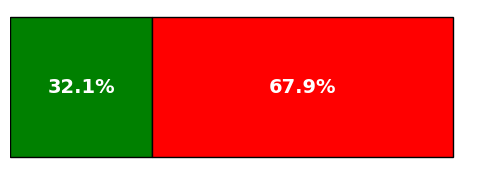

In [13]:
prop = agg_df['Attrition'].value_counts(normalize=True).sort_index()

fig, ax = plt.subplots(figsize=(6, 2))
ax.barh(0, prop[0], color=attrition_palette1[0], edgecolor='black')
ax.barh(0, prop[1], left=prop[0], color=attrition_palette1[1], edgecolor='black')

ax.text(prop[0] / 2, 0, f'{prop[0]*100:.1f}%', va='center', ha='center', color='white', fontweight='bold', fontsize=14)
ax.text(prop[0] + prop[1] / 2, 0, f'{prop[1]*100:.1f}%', va='center', ha='center', color='white', fontweight='bold', fontsize=14)

ax.set(yticks=[], xticks=[])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

The dataset is imbalanced, with approximately 68% of drivers having churned and 32% remaining active.
We will use the color palette red to represent churn and green to represent non-churn drivers throughout the EDA.


##Outlier Detection

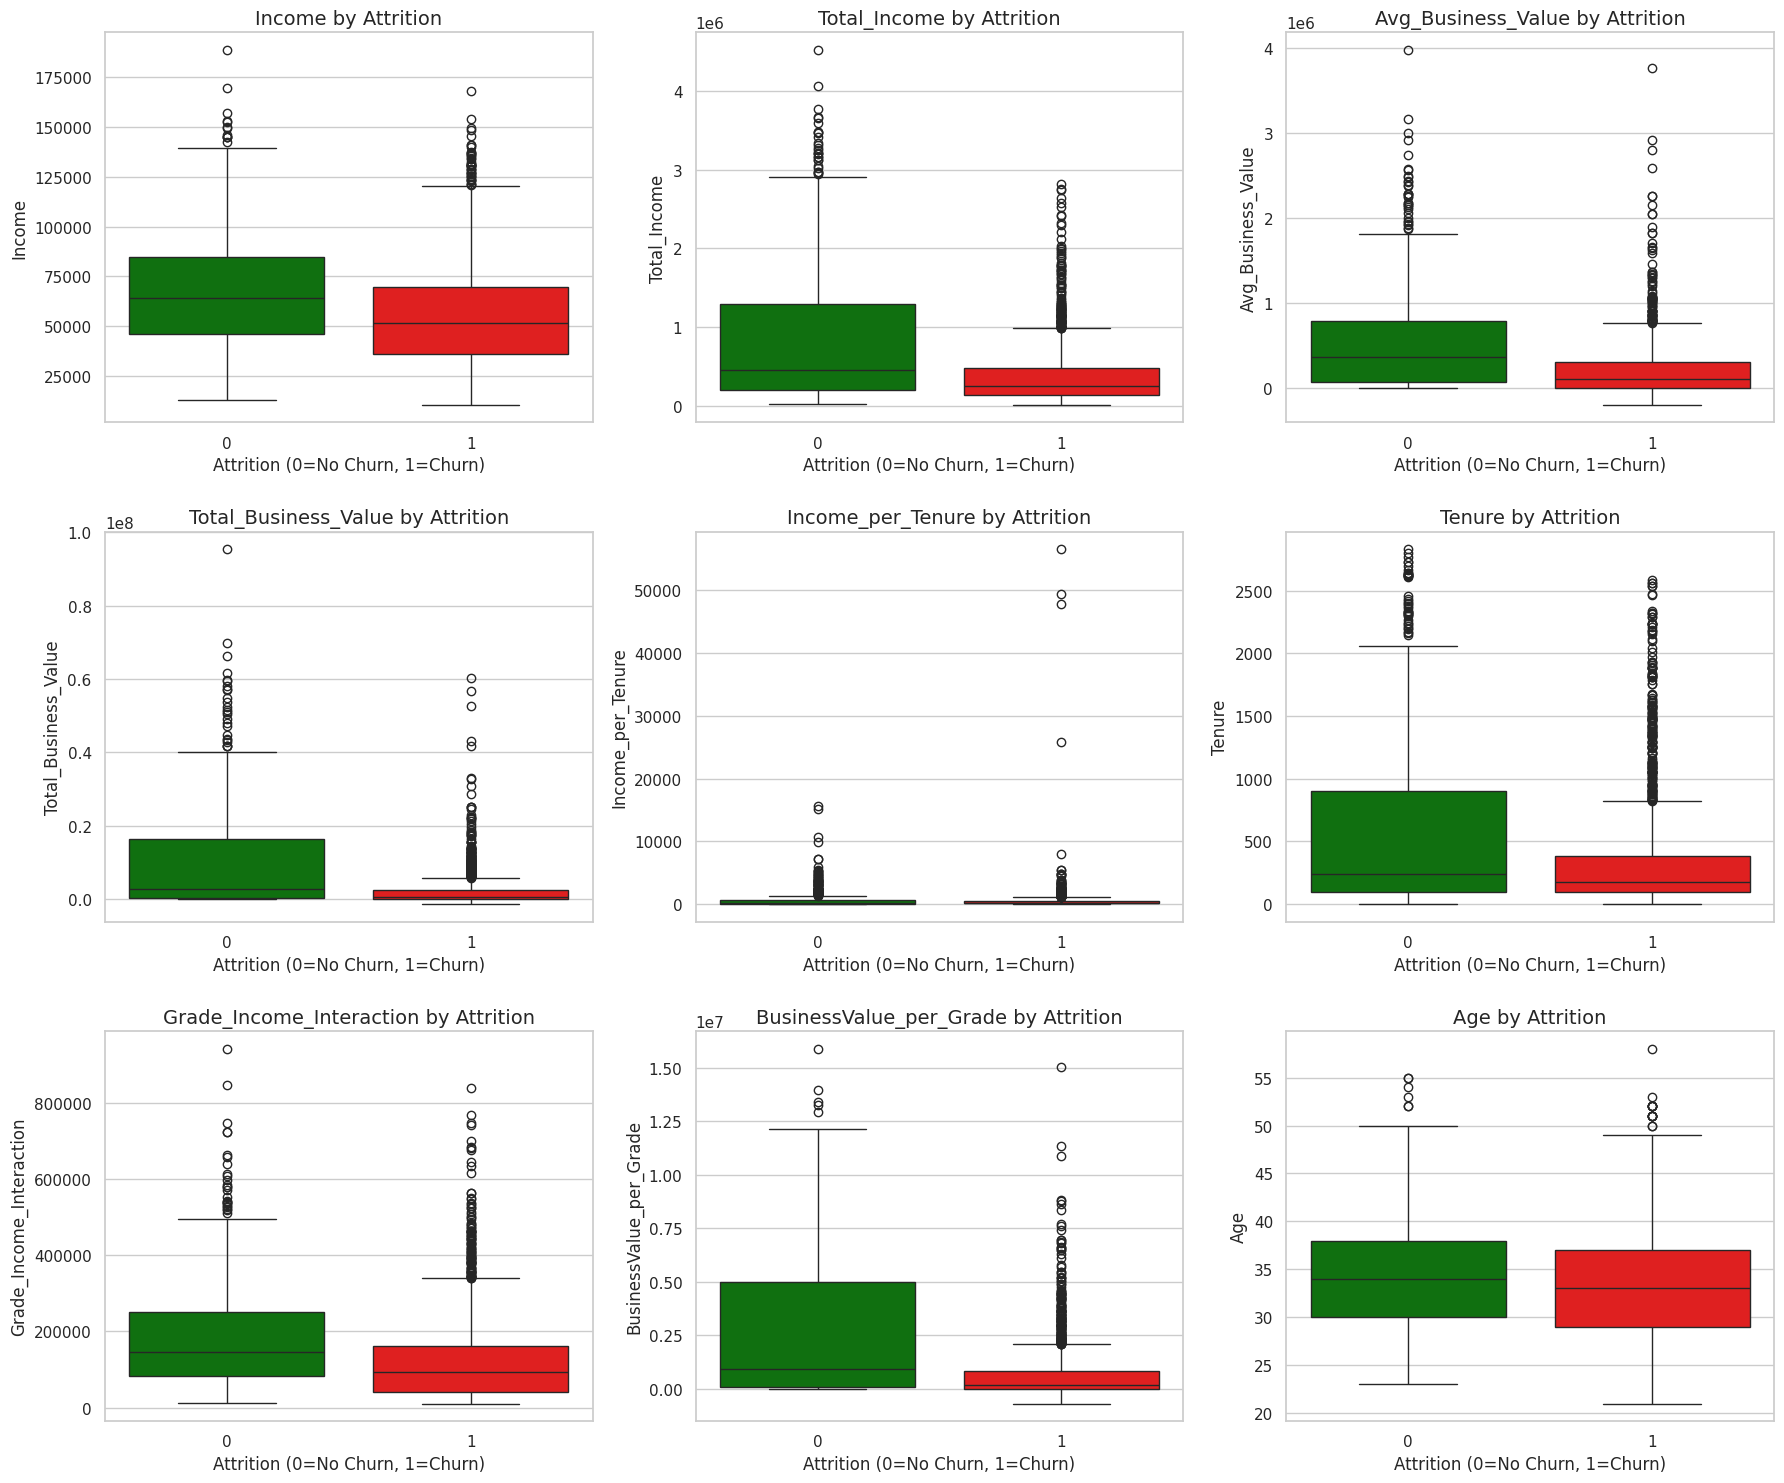

In [14]:
cols_to_plot = [
    'Income', 'Total_Income', 'Avg_Business_Value', 'Total_Business_Value',
    'Income_per_Tenure', 'Tenure', 'Grade_Income_Interaction', 'BusinessValue_per_Grade', 'Age'
]

sns.set(style='whitegrid')

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.boxplot(x='Attrition', y=col, data=agg_df, palette=attrition_palette, ax=axes[i])
    axes[i].set_title(f'{col} by Attrition', fontsize=14)
    axes[i].set_xlabel('Attrition (0=No Churn, 1=Churn)')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

### Observation

- Outliers are minimal across features, especially in:
  - Age
  - Income per tenure
- Churned drivers exhibit fewer outliers overall compared to non-churned drivers.
- Attrition related to tenure shows many outliers.
- This suggests that extreme values are less common in the churn group, possibly reflecting a more homogeneous group of low-performing or low-earning drivers leaving the organization.


##Univariate Numerical Analysis

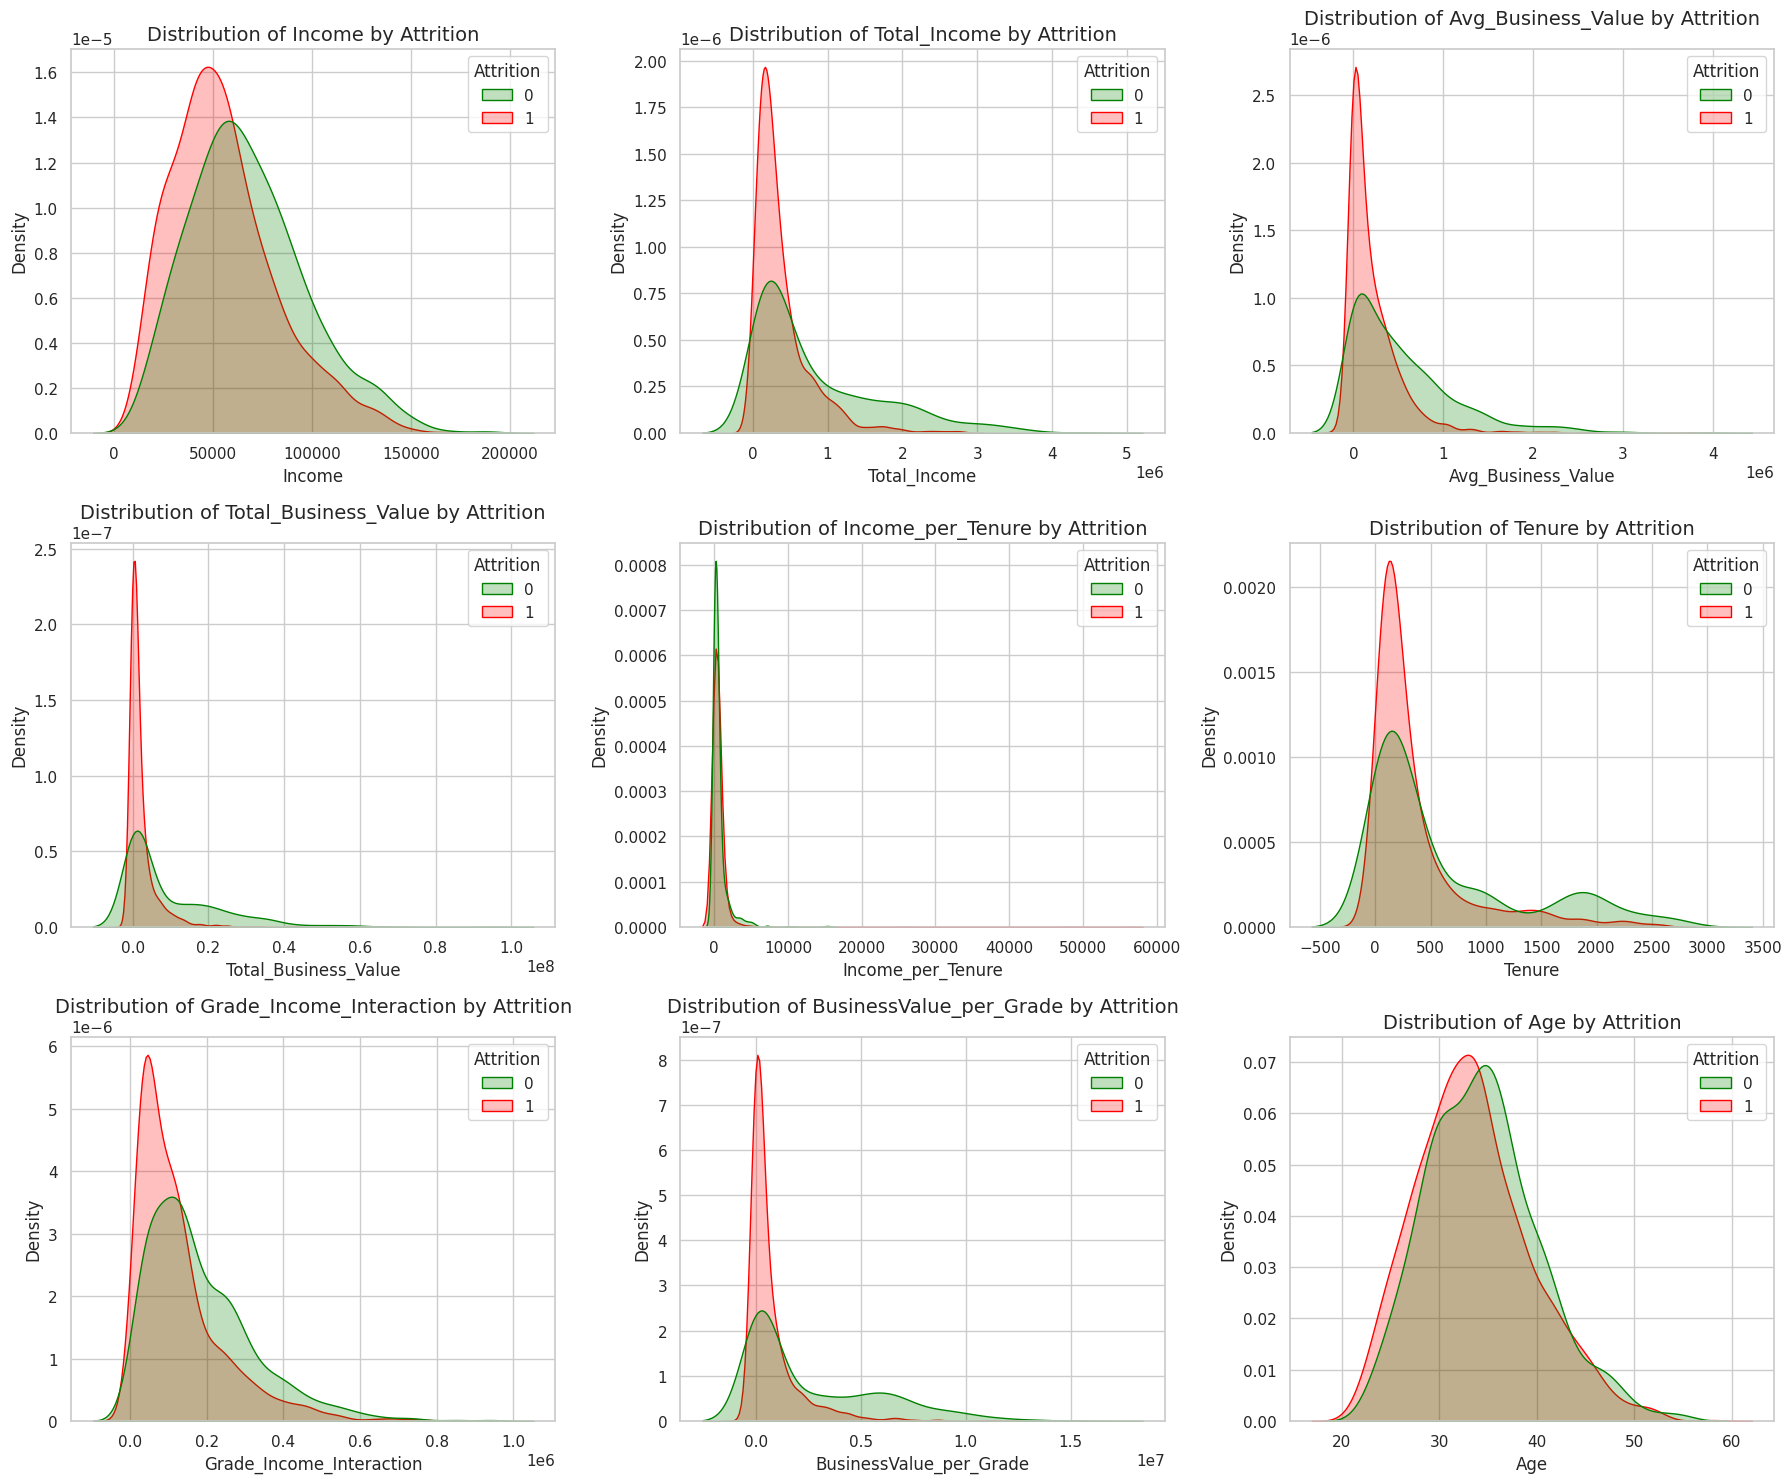

In [15]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.kdeplot(
        data=agg_df,
        x=col,
        hue='Attrition',
        palette=attrition_palette1,
        fill=True,
        common_norm=False,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {col} by Attrition', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

### Univariate Observations (Boxplots and KDE)

- **Income & Total Income:** Churned drivers earn lower and more similar incomes, with narrower distributions compared to retained drivers.
- **Business Value:** Churned drivers show higher peaks at lower business values, especially when normalized by grade.
- **Tenure:** Churned drivers have shorter tenure; retained drivers have longer, right-skewed tenure distributions.
- **Age:** Little difference between churned and retained groups.
- **Grade:** Minor variation between the two groups.
- **Overall:** Lower income and business contributions correlate with higher churn risk.


## Categorical Variable Analysis

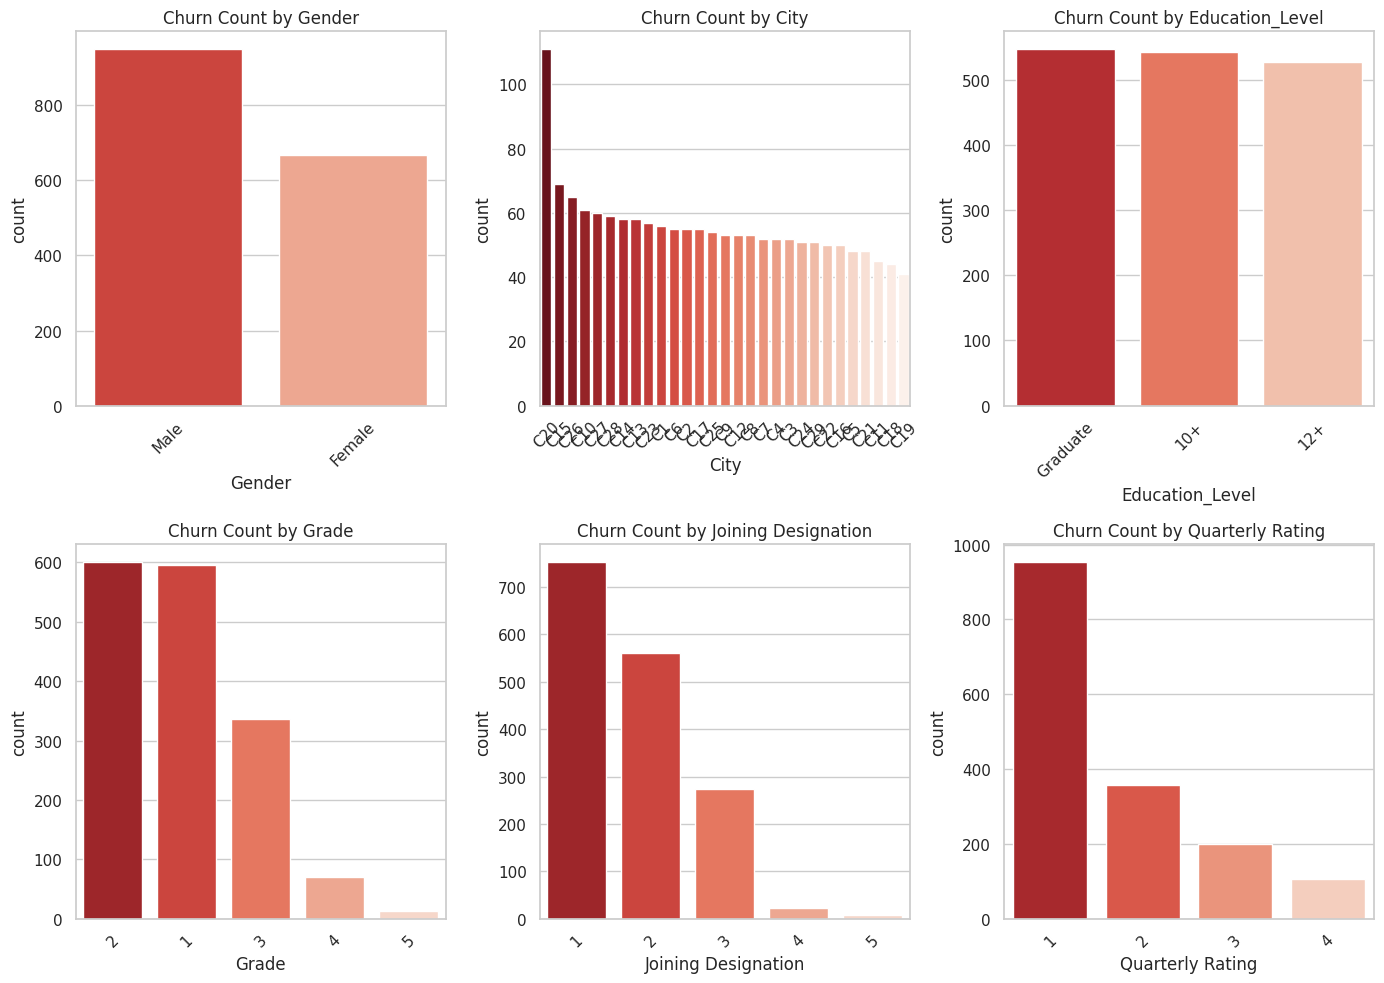

In [16]:
churned_df = agg_df[agg_df['Attrition'] == 1].copy()

gender_labels = {'0': 'Male', '1': 'Female'}
education_labels = {'0': '10+', '1': '12+', '2': 'Graduate'}

cat_cols = ['Gender', 'City', 'Education_Level', 'Grade', 'Joining Designation', 'Quarterly Rating']

churned_df[cat_cols] = churned_df[cat_cols].astype(str).fillna('Unknown')

fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    counts = churned_df[col].value_counts()
    order = counts.index.tolist()
    base_palette = sns.color_palette("Reds", n_colors=len(order))
    palette = dict(zip(order, base_palette[::-1]))

    ax = axes[i]
    sns.countplot(data=churned_df, x=col, order=order, palette=palette, ax=ax)

    if col == 'Gender':
        ax.set_xticklabels([gender_labels.get(label, label) for label in order], rotation=45)
    elif col == 'Education_Level':
        ax.set_xticklabels([education_labels.get(label, label) for label in order], rotation=45)
    else:
        ax.tick_params(axis='x', rotation=45)

    ax.set_title(f'Churn Count by {col}')

plt.tight_layout()
plt.show()

### Observations

To uncover attrition patterns, we focus on **churned drivers** to identify **at-risk segments** based on demographics, performance, and location. This targeted approach enables precise retention strategies and improved churn prediction.

- **Gender:** More male drivers have churned, likely reflecting Ola’s predominantly male driver base.
- **City:** Drivers from **City C20** show the highest churn rates, indicating possible regional or operational challenges.
- **Education Level:** Churn rates are similar across education levels, with only marginally higher churn among graduates.
- **Grade:** Drivers with **lower grades** churn more frequently, suggesting links to performance or experience.
- **Joining Designation:** Higher churn among drivers who joined at **lower designations**, possibly due to limited growth or unmet expectations.
- **Quarterly Rating:** Lower ratings correlate strongly with higher churn.


### Overall Insight

Churn is concentrated among drivers with **lower performance indicators** (grades, designations, ratings), with additional influence from **regional factors** (notably City C20) and a **male-skewed workforce**. These findings support the development of targeted retention efforts for vulnerable driver groups.


### Binary Flag Analysis

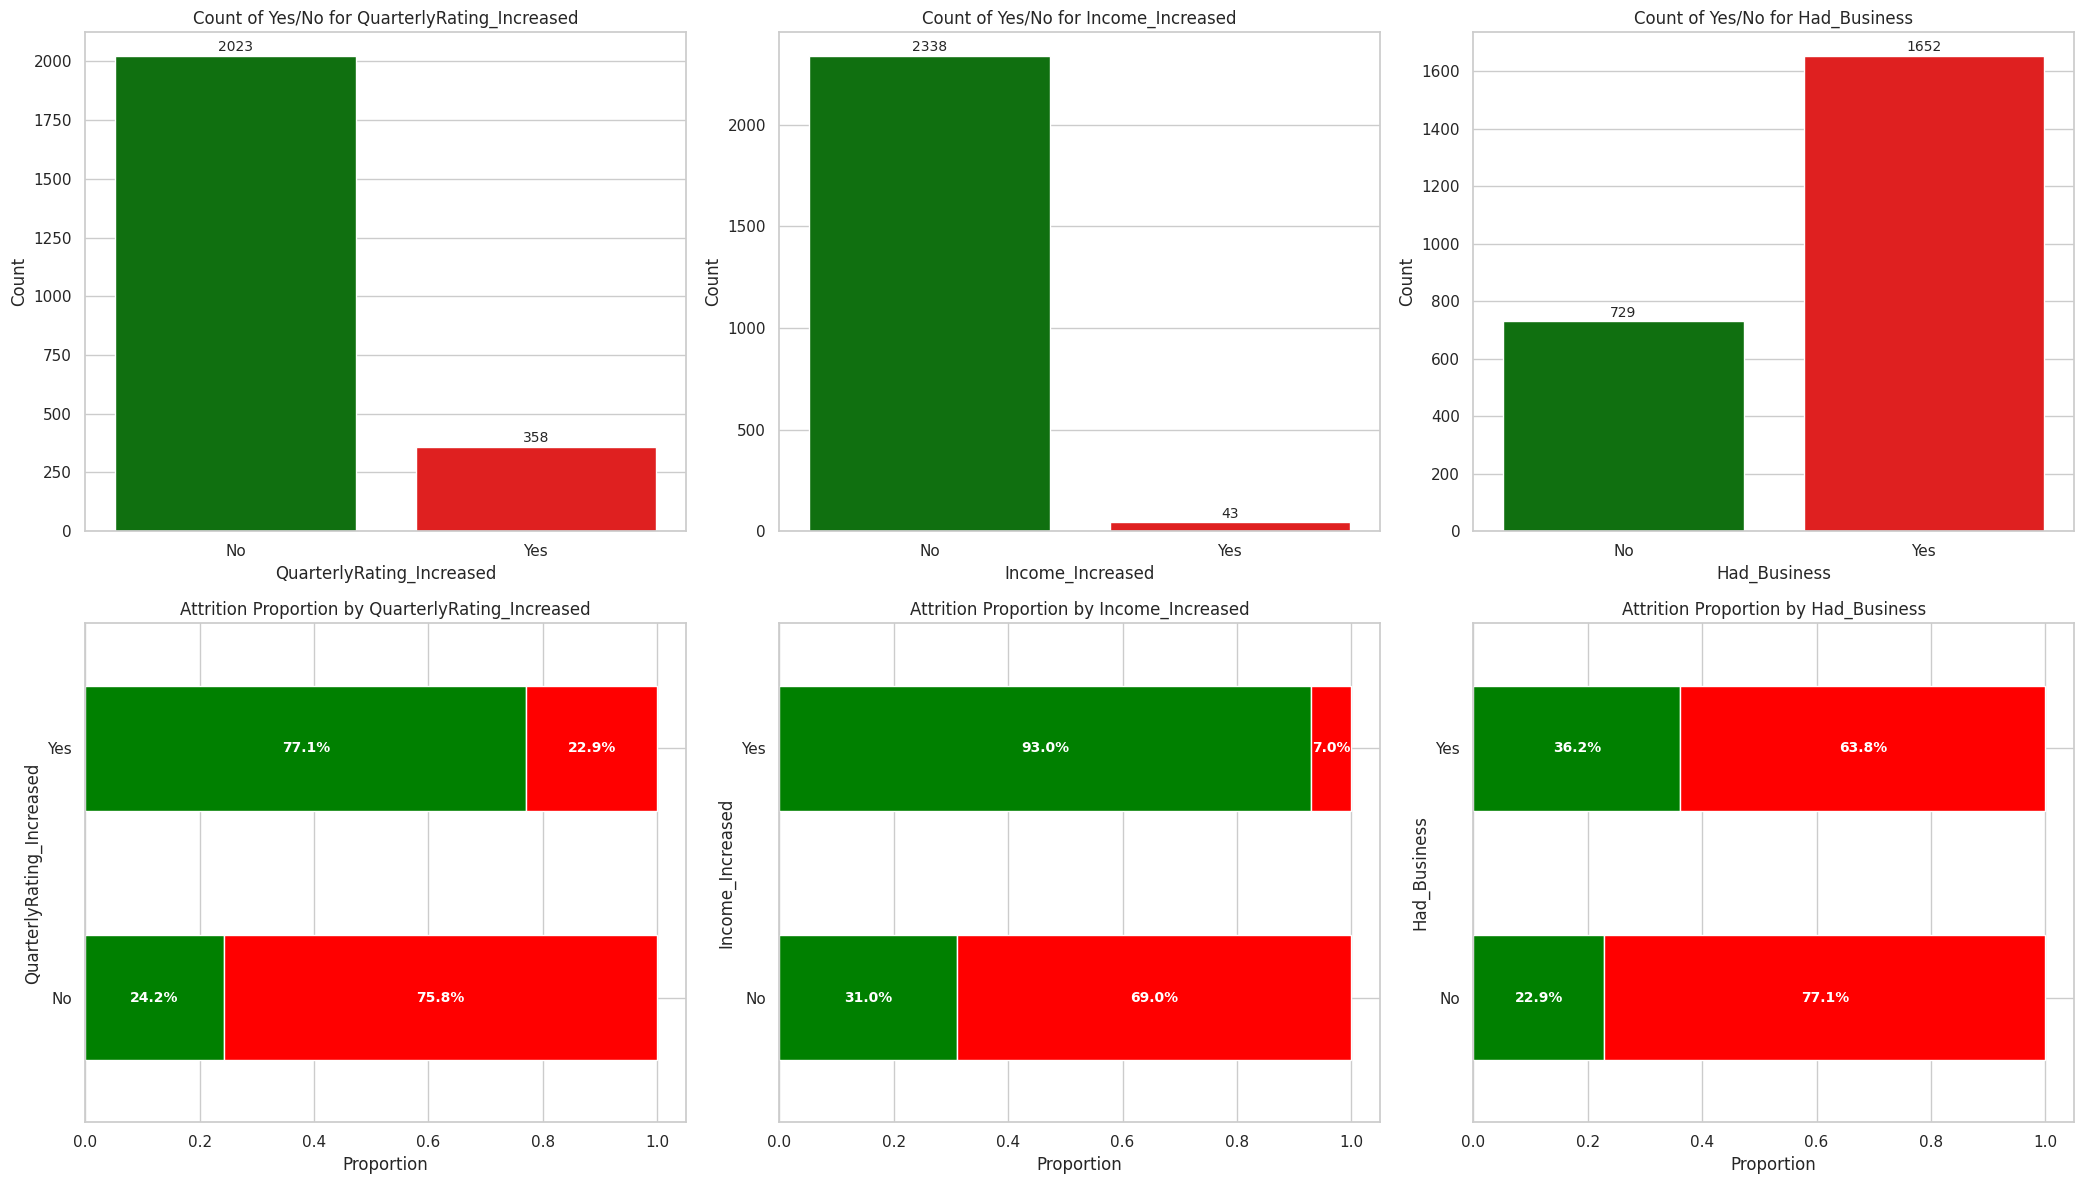

In [17]:
sns.set(style="whitegrid")

plot_df = agg_df.copy()
for col in ['QuarterlyRating_Increased', 'Income_Increased', 'Had_Business', 'Attrition']:
    plot_df[col] = plot_df[col].map({0: 'No', 1: 'Yes'})

palette = {'No': 'green', 'Yes': 'red'}

fig, axes = plt.subplots(2, 3, figsize=(21, 12))
axes = axes.flatten()

def plot_counts(ax, feature):
    counts = plot_df[feature].value_counts().reindex(['No', 'Yes'])
    sns.barplot(
        x=counts.index,
        y=counts.values,
        palette=[palette[x] for x in counts.index],
        ax=ax
    )
    ax.set_ylabel('Count')
    ax.set_title(f'Count of Yes/No for {feature}')
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(counts.values)*0.01, str(v), ha='center', fontsize=10)

def plot_prop(ax, feature):
    prop_df = plot_df.groupby([feature, 'Attrition']).size().unstack(fill_value=0)
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
    prop_df.plot(
        kind='barh',
        stacked=True,
        color=[palette[col] for col in prop_df.columns],
        ax=ax,
        legend=False
    )
    ax.set_xlabel('Proportion')
    ax.set_ylabel(feature)
    ax.set_title(f'Attrition Proportion by {feature}')
    for i, row in enumerate(prop_df.itertuples(index=False)):
        cum = 0
        for val, col in zip(row, prop_df.columns):
            if val > 0.02:
                ax.text(
                    cum + val / 2, i,
                    f'{val*100:.1f}%',
                    ha='center', va='center',
                    color='white',
                    fontsize=10,
                    fontweight='bold'
                )
            cum += val

features = ['QuarterlyRating_Increased', 'Income_Increased', 'Had_Business']

for i, feat in enumerate(features):
    plot_counts(axes[i], feat)
    plot_prop(axes[i + 3], feat)

plt.tight_layout()
plt.show()

#### Observations

1. **Quarterly Rating Increase**  
   - 358 drivers experienced an increase; 2,338 did not.  
   - Among those with increased ratings, 77% remain and 23% have churned.  
   - Among those without increase, 24% remain and 76% have churned.

2. **Income Increase**  
   - 43 drivers had income growth; 2,338 did not.  
   - Of those with income increase, 93% remain and 7% churned.  
   - Among those without income growth, 31% remain and 69% churned.

3. **Business Contribution**  
   - 1,652 drivers generated positive business value; 729 had zero or negative.  
   - Churn rates: 63.8% for positive contributors, 77% for non-contributors.


These findings indicate that increases in rating and income are linked to higher retention, and contributing business value correlates with lower churn.

Drivers showing positive trends in performance and income, along with business contribution, are significantly more likely to stay. Focusing retention efforts on those with stagnant or declining performance and incentivizing business contributions can help reduce churn and boost engagement.


## Seasonality Analysis

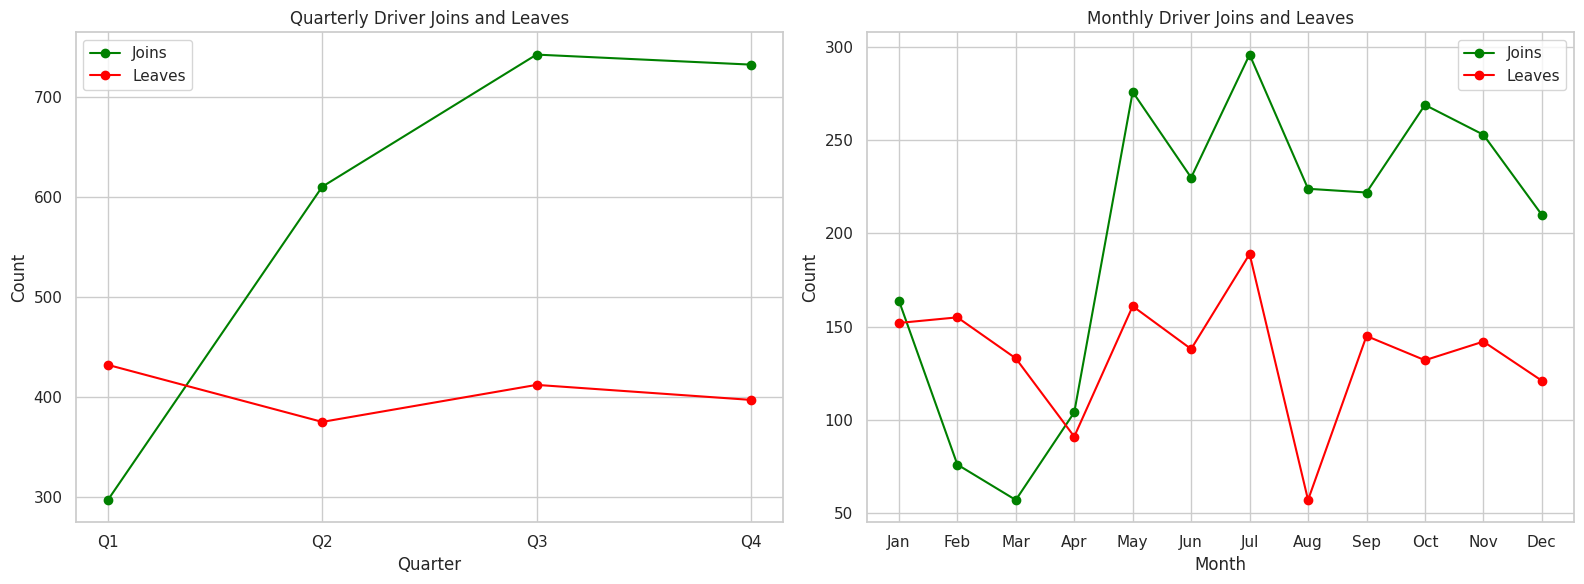

In [18]:
agg_df['Leaving_Month'] = agg_df['Last_Working_Date'].dt.month

monthly_joins = agg_df.groupby('Joining_Month').size().sort_index()
monthly_leaves = agg_df[agg_df['Attrition'] == 1].groupby('Leaving_Month').size().sort_index()

quarterly_joins = agg_df.groupby('Joining_Quarter').size().sort_index()
quarterly_leaves = agg_df[agg_df['Attrition'] == 1].groupby('Reporting_Quarter').size().sort_index()

monthly_data = (
    monthly_joins.to_frame(name='Joins')
    .join(monthly_leaves.to_frame(name='Leaves'), how='outer')
    .fillna(0)
)

quarterly_data = (
    quarterly_joins.to_frame(name='Joins')
    .join(quarterly_leaves.to_frame(name='Leaves'), how='outer')
    .fillna(0)
)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(quarterly_data.index, quarterly_data['Joins'], marker='o', label='Joins', color=attrition_palette1[0])
axs[0].plot(quarterly_data.index, quarterly_data['Leaves'], marker='o', label='Leaves', color=attrition_palette1[1])
axs[0].set_xticks(range(1, 5))
axs[0].set_xticklabels(quarters)
axs[0].set_xlabel('Quarter')
axs[0].set_ylabel('Count')
axs[0].set_title('Quarterly Driver Joins and Leaves')
axs[0].legend()

axs[1].plot(monthly_data.index, monthly_data['Joins'], marker='o', label='Joins', color=attrition_palette1[0])
axs[1].plot(monthly_data.index, monthly_data['Leaves'], marker='o', label='Leaves', color=attrition_palette1[1])
axs[1].set_xticks(range(1, 13))
axs[1].set_xticklabels(months)
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Count')
axs[1].set_title('Monthly Driver Joins and Leaves')
axs[1].legend()

plt.tight_layout()
plt.show()

- Q1 experiences more drivers leaving than joining, indicating a net workforce loss early in the year. This may result from reduced demand post-holiday season or drivers transitioning jobs.

- Q2, Q3, and Q4 see significantly higher driver join counts, with Q3 recording the highest new joins, likely due to rising demand during festive seasons and strategic recruitment efforts.

- February and March have more drivers leaving than joining, highlighting these months as critical for attrition. Possible reasons include contract renewals, academic year endings, or seasonal job changes.

- August shows the lowest number of drivers leaving, suggesting better retention or workforce stability, potentially due to festivals that encourage drivers to stay longer for increased earnings.

- July records the highest number of driver joins, marking it as the peak hiring month, likely driven by pre-festival demand buildup and mid-year recruitment campaigns.


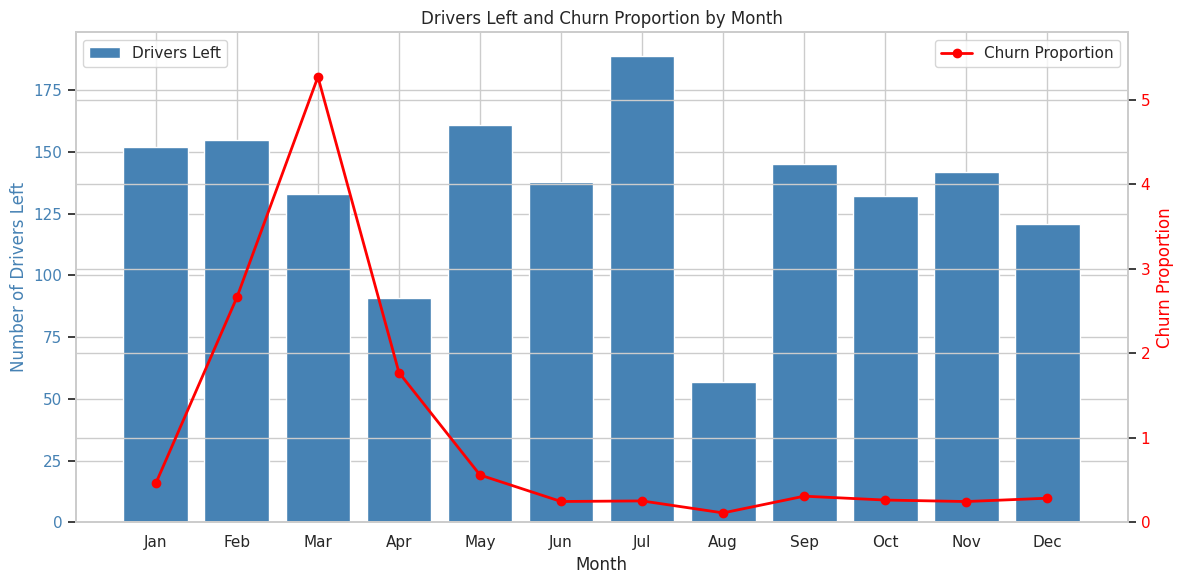

In [19]:
left_drivers = agg_df[agg_df['Attrition'] == 1].copy()
left_drivers['Leaving_Year'] = left_drivers['Last_Working_Date'].dt.year
left_drivers['Leaving_Month'] = left_drivers['Last_Working_Date'].dt.month

agg_df['Joining_Year'] = agg_df['Joining_Date'].dt.year
agg_df['Joining_Month'] = agg_df['Joining_Date'].dt.month

left_counts_month = left_drivers.groupby('Leaving_Month').size()

joined_per_month_year = agg_df.groupby(['Joining_Year', 'Joining_Month']).size()
left_counts_month_year = left_drivers.groupby(['Leaving_Year', 'Leaving_Month']).size()
left_counts_month_year.index.names = ['Joining_Year', 'Joining_Month']

churn_prop = (left_counts_month_year / joined_per_month_year).fillna(0)
churn_prop_by_month = churn_prop.groupby('Joining_Month').mean()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(left_counts_month.index, left_counts_month.values, color='steelblue', label='Drivers Left')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Drivers Left', color='steelblue')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(churn_prop_by_month.index, churn_prop_by_month.values, color='red', marker='o', linewidth=2, label='Churn Proportion')
ax2.set_ylabel('Churn Proportion', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, churn_prop_by_month.max() * 1.1)

plt.title('Drivers Left and Churn Proportion by Month')
fig.tight_layout()

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### Q: When do drivers leave during the year?

- **July has the highest number of drivers leaving**, indicating a bulk exit likely related to seasonal trends or contract cycles. This significantly impacts operational capacity and requires proactive workforce planning.

- **March records the highest churn rate**, suggesting drivers active during this period are more likely to leave, highlighting retention challenges that need targeted interventions.

**Business action:**  
Focus retention initiatives on drivers around March to lower churn risk, and prepare for operational fluctuations in July through hiring drives or incentive programs. Understanding these trends enables better driver engagement and service quality maintenance.


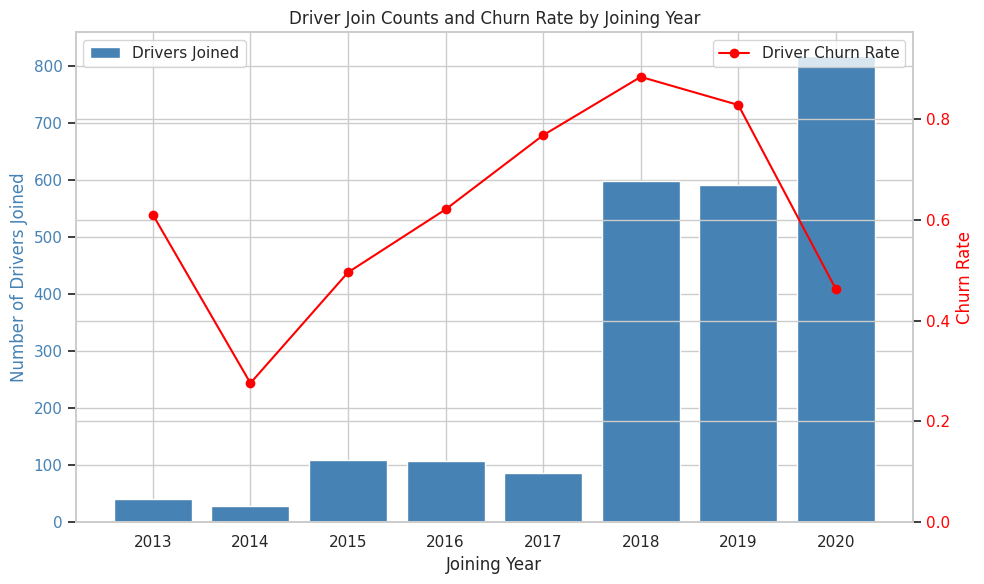

In [20]:
agg_df['Joining_Year'] = agg_df['Joining_Date'].dt.year

joined_per_year = agg_df.groupby('Joining_Year').size()
churn_rate = agg_df.groupby('Joining_Year')['Attrition'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(joined_per_year.index, joined_per_year.values, color='steelblue', label='Drivers Joined')
ax1.set_xlabel('Joining Year')
ax1.set_ylabel('Number of Drivers Joined', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(churn_rate.index, churn_rate.values, color='red', marker='o', label='Driver Churn Rate')
ax2.set_ylabel('Churn Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, churn_rate.max() * 1.1)

plt.title('Driver Join Counts and Churn Rate by Joining Year')
fig.tight_layout()

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### Q: How does retention vary depending on the year drivers joined?

- **Rapid Driver Growth (2018–2020):** Driver joins surged sharply from 2018, peaking near 800 in 2020, reflecting major expansion.
- **Churn Spike in 2018:** The churn rate reached its highest (~85%) in 2018, coinciding with the rapid influx of new drivers.
- **Improved Retention in 2020:** Despite record driver joins, the 2020 cohort’s churn dropped significantly to around 40%, indicating better retention.
- **Early Years Fluctuation (2013–2017):** Join counts and churn rates were unstable, with a notable churn dip in 2014, followed by rising churn alongside modest driver growth through 2017.

**Overall:**  
After early volatility, the driver base grew explosively starting in 2018, initially accompanied by high churn. However, retention improved substantially by 2020, suggesting effective driver engagement and retention strategies.


## City-Level Analysis

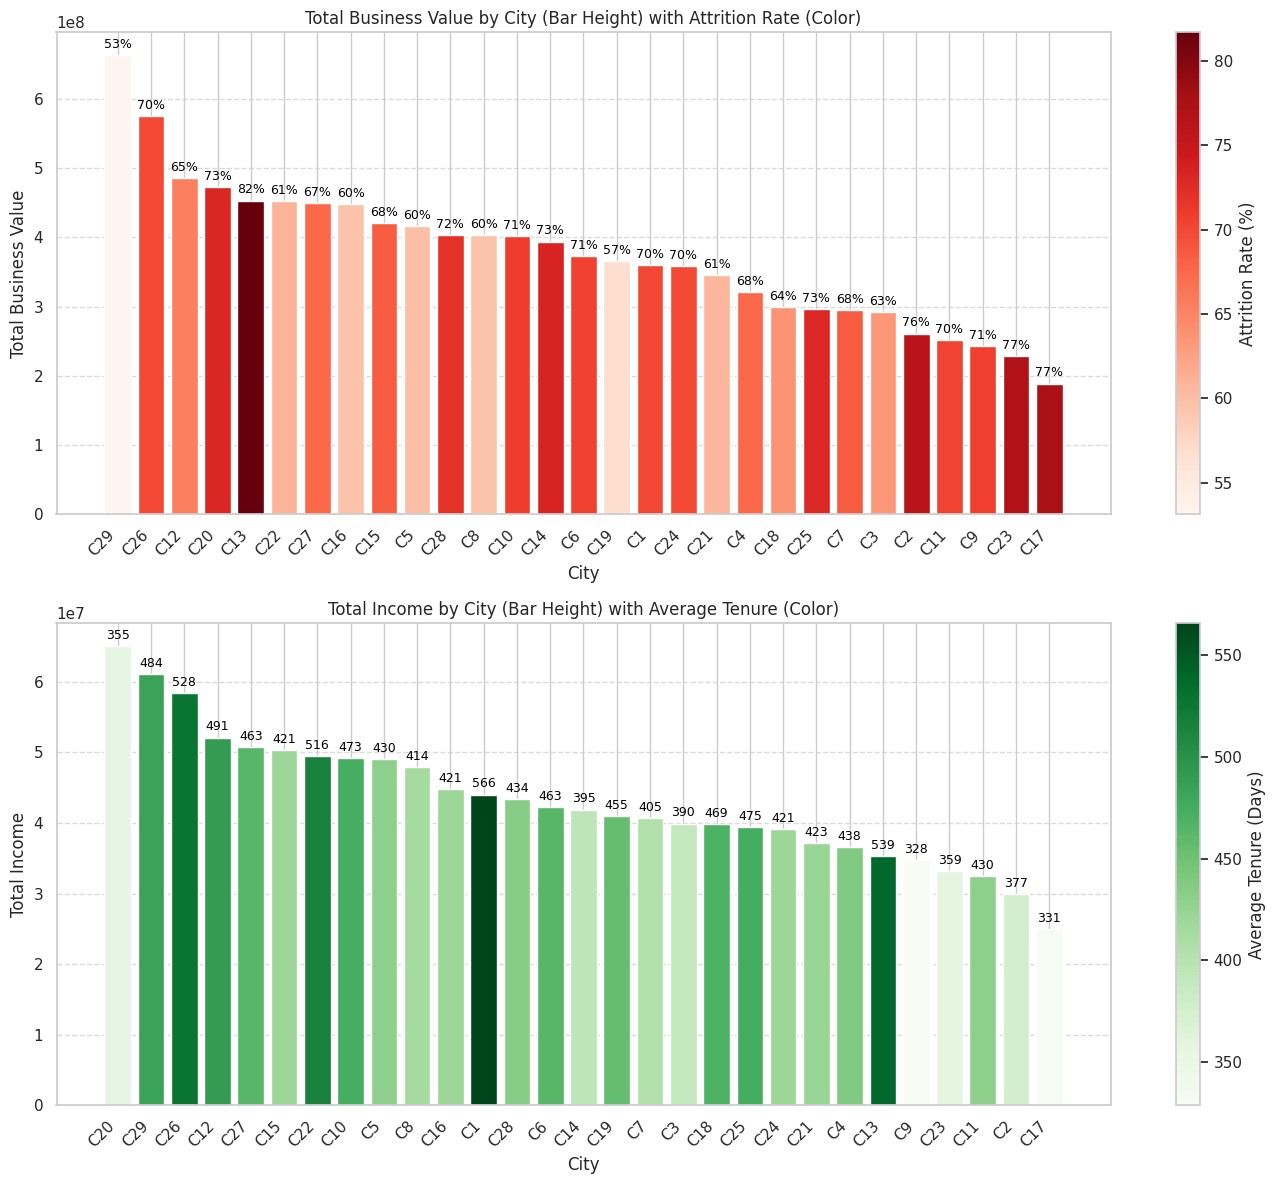

In [21]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

city_joins = agg_df.groupby('City')['Joining_Date'].count()
city_leaves = agg_df[agg_df['Last_Working_Date'].notna()].groupby('City')['Last_Working_Date'].count()
city_business = agg_df.groupby('City')['Total_Business_Value'].sum()

city_attrition = pd.concat([city_joins, city_leaves, city_business], axis=1)
city_attrition.columns = ['Total_Joins', 'Total_Leaves', 'Total_Business_Value']
city_attrition['Attrition_Rate (%)'] = (city_attrition['Total_Leaves'] / city_attrition['Total_Joins']) * 100
city_attrition = city_attrition.dropna().sort_values('Total_Business_Value', ascending=False)

norm1 = mcolors.Normalize(vmin=city_attrition['Attrition_Rate (%)'].min(), vmax=city_attrition['Attrition_Rate (%)'].max())
cmap1 = cm.get_cmap('Reds')
colors1 = [cmap1(norm1(val)) for val in city_attrition['Attrition_Rate (%)']]

bars1 = axes[0].bar(city_attrition.index, city_attrition['Total_Business_Value'], color=colors1)
for bar, attr_rate in zip(bars1, city_attrition['Attrition_Rate (%)']):
    axes[0].annotate(
        f'{int(round(attr_rate))}%',
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=axes[0])
cbar1.set_label('Attrition Rate (%)')

axes[0].set_title('Total Business Value by City (Bar Height) with Attrition Rate (Color)')
axes[0].set_ylabel('Total Business Value')
axes[0].set_xlabel('City')
axes[0].set_xticklabels(city_attrition.index, rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

city_income = agg_df.groupby('City')['Total_Income'].sum().sort_values(ascending=False)
city_tenure = agg_df.groupby('City')['Tenure'].mean().loc[city_income.index]

norm2 = mcolors.Normalize(vmin=city_tenure.min(), vmax=city_tenure.max())
cmap2 = cm.get_cmap('Greens')
colors2 = [cmap2(norm2(val)) for val in city_tenure]

bars2 = axes[1].bar(city_income.index, city_income.values, color=colors2)
for bar, tenure in zip(bars2, city_tenure):
    axes[1].annotate(
        f'{int(round(tenure))}',
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=axes[1])
cbar2.set_label('Average Tenure (Days)')

axes[1].set_title('Total Income by City (Bar Height) with Average Tenure (Color)')
axes[1].set_ylabel('Total Income')
axes[1].set_xlabel('City')
axes[1].set_xticklabels(city_income.index, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

These two city-wise graphs provide complementary perspectives—one highlights churn risk relative to business value, while the other reveals tenure patterns linked to income stability. Together, they offer actionable insights for prioritizing retention and growth strategies.

### Graph 1: Total Business Value vs Attrition Rate by City  
**Q: Which cities generate high business value but also suffer from high driver attrition?**

- **Bar Height:** Total Business Value  
- **Color Intensity:** Attrition Rate (darker red = higher attrition)

#### Key Observations:
- **City C29** leads with the highest total business value and one of the lowest attrition rates, indicating a strong and stable market.
- **City C13** ranks 4th in business value but has a high attrition rate of 82%, making it a critical area needing focused retention efforts to boost business value.
- **City C20** ranks 3rd in business value with a high attrition rate of 73%, similarly requiring intervention.
- **City C26** is 3rd in business value with an average attrition rate and should be prioritized for retention strategies.
- **Cities C23 and C17** have the lowest business values combined with very high attrition rates, suggesting a need to reevaluate strategies, possibly reallocating resources or considering divestment.
- **City C19** and **City C8** exhibit average business value but low attrition, presenting opportunities for growth through driver or service expansion.
- **City C16** has above-average business value with low attrition, highlighting it as another stable region worth investment.

### Business Insights

- **Prioritize retention efforts in cities with high business value but elevated attrition**, such as C13 and C20, to maximize ROI by reducing churn among valuable drivers.
- **Focus on strengthening stable markets like C29, C16, C19, and C8**, where attrition is low and business value is moderate to high, to sustain and grow their performance further.
- **Reevaluate strategies in cities with low business value and high attrition, like C23 and C17**, which may require operational changes, resource reallocation, or divestment to improve efficiency.
- **Tailor region-specific retention programs** addressing unique challenges—such as targeted incentives in high-churn cities and growth investments in stable cities—to optimize overall driver retention and business growth.

### Graph 2: Total Income vs Average Tenure by City  
**Q: How does driver tenure influence total income generation across cities?**

- **Bar Height**: Total Income (descending order)  
- **Bar Color**: Average Tenure (dark green = longer tenure)

#### Key Observations:
-C20 is highest earning city but drivers stay for small tenure less than an year
-C29 and C12 have high income and average tunure. tenure can be imploved
- C26 stands out with high income and long driver tenure, reinforcing it as a **model city**.
-C1 has average income but strongest tenure
-C13 has very strong tenure but oncome on lower side
- C2 and C17 show low income and short tenure, potentially signaling inefficiencies or market saturation.

---

## Business Insights

- **High-priority retention zones**: C13, C26, C20 — reduce churn to protect high revenue.
- **Evaluate for strategic action**: C23, C17 — consider restructuring, incentives, or reallocation.
- **Best practices cities**: C29 (high value, low attrition, long tenure) and C19 (low attrition, loyal base).
- Replicate success in similar markets using C29 and C19 strategies for tenure, onboarding, and support.


## MultiColinearity Detection

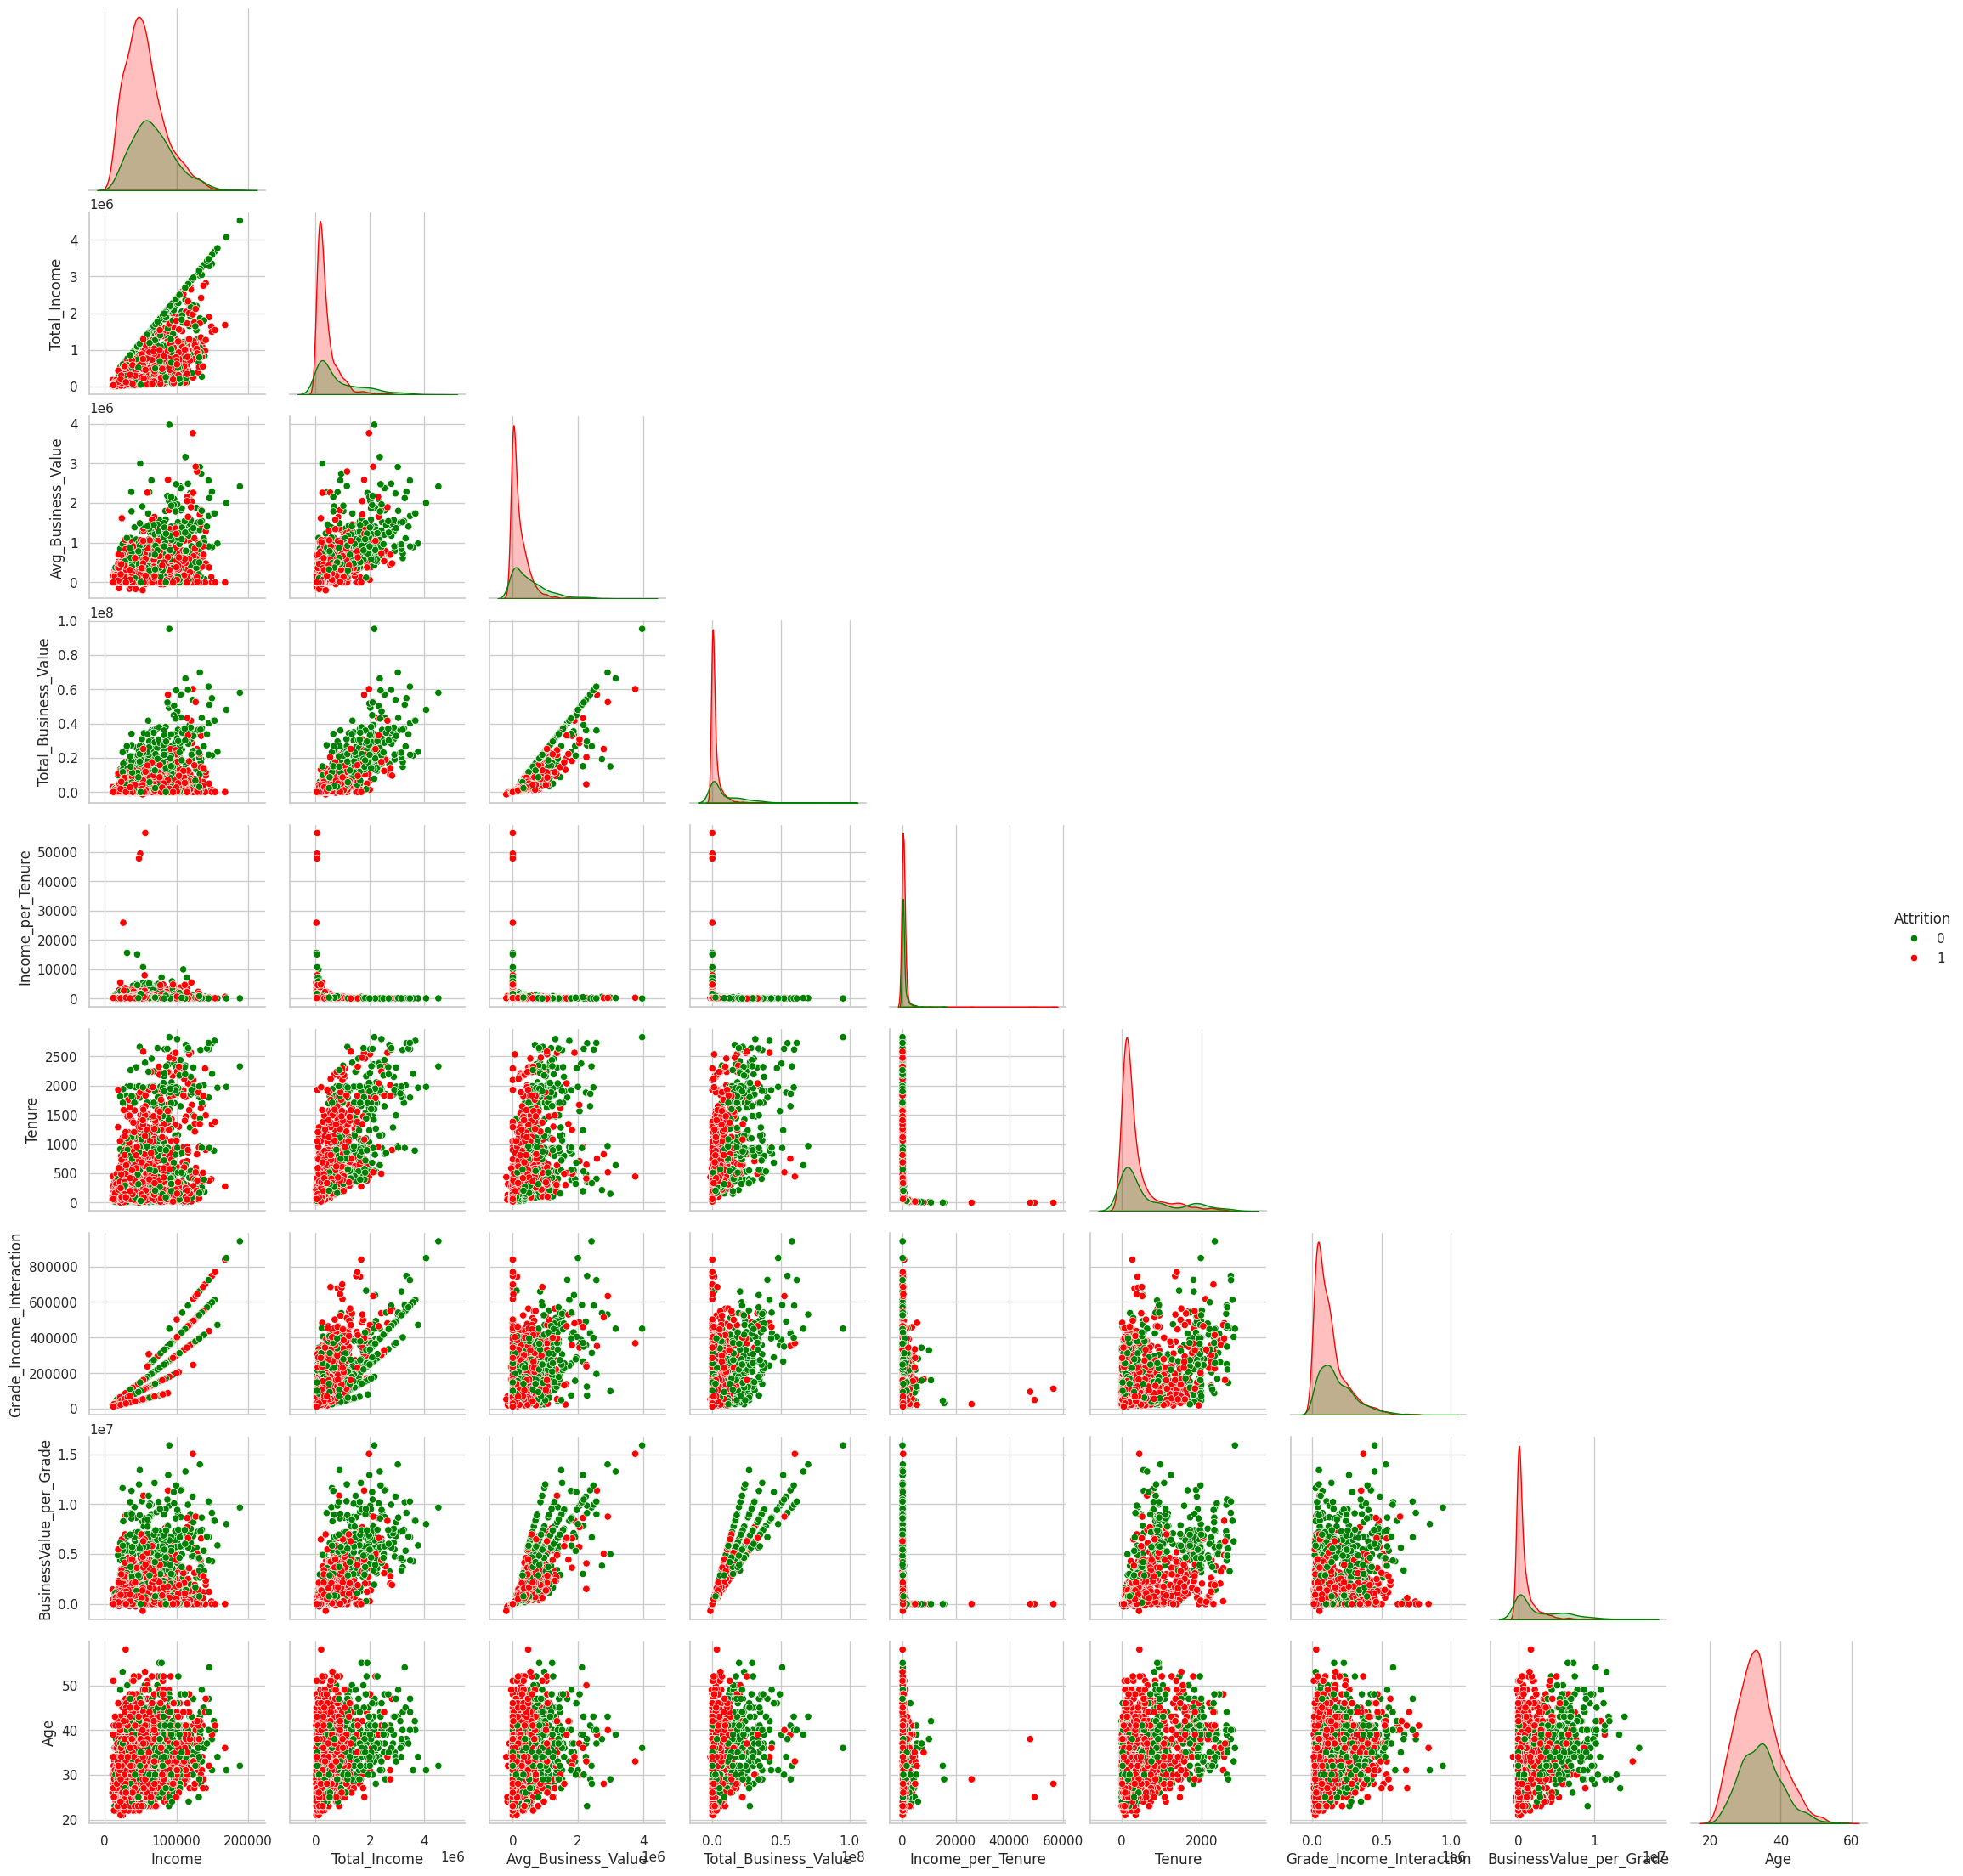

In [22]:
sns.pairplot(agg_df[cols_to_plot + ['Attrition']],
             hue='Attrition',
             diag_kind='kde',
             corner=True,
             palette=attrition_palette1)
plt.show()

### Observations from Pairplot

Based on the pairplot, we observe the following:

- `Grade_Income_Interaction` shows a strong linear relationship with both `Income` (latest income) and `Total_Income`, indicating potential redundancy.
- `Avg_Business_Value` is strongly related to both `Total_Business_Value` and `BusinessValue_per_Grade`, suggesting these features form a multicollinear group.
- `Income_per_Tenure` has a highly skewed and sparse distribution, making it a weak candidate for predictive modeling.

These visual cues point to potential multicollinearity or redundancy among several features. We will validate these findings using a correlation heatmap.

While the pairplot suggests that `Grade_Income_Interaction` is largely explained by its components (`Grade` and `Income`) and that `Avg_Business_Value` overlaps heavily with `Total_Business_Value`, final feature selection will be based on correlation analysis. However, we are confident in dropping `Income_per_Tenure` due to its poor distribution.

Next, we will include temporal features such as `Joining_Month` and `Joining_Quarter` to evaluate correlations across time-based variables and determine which to retain.


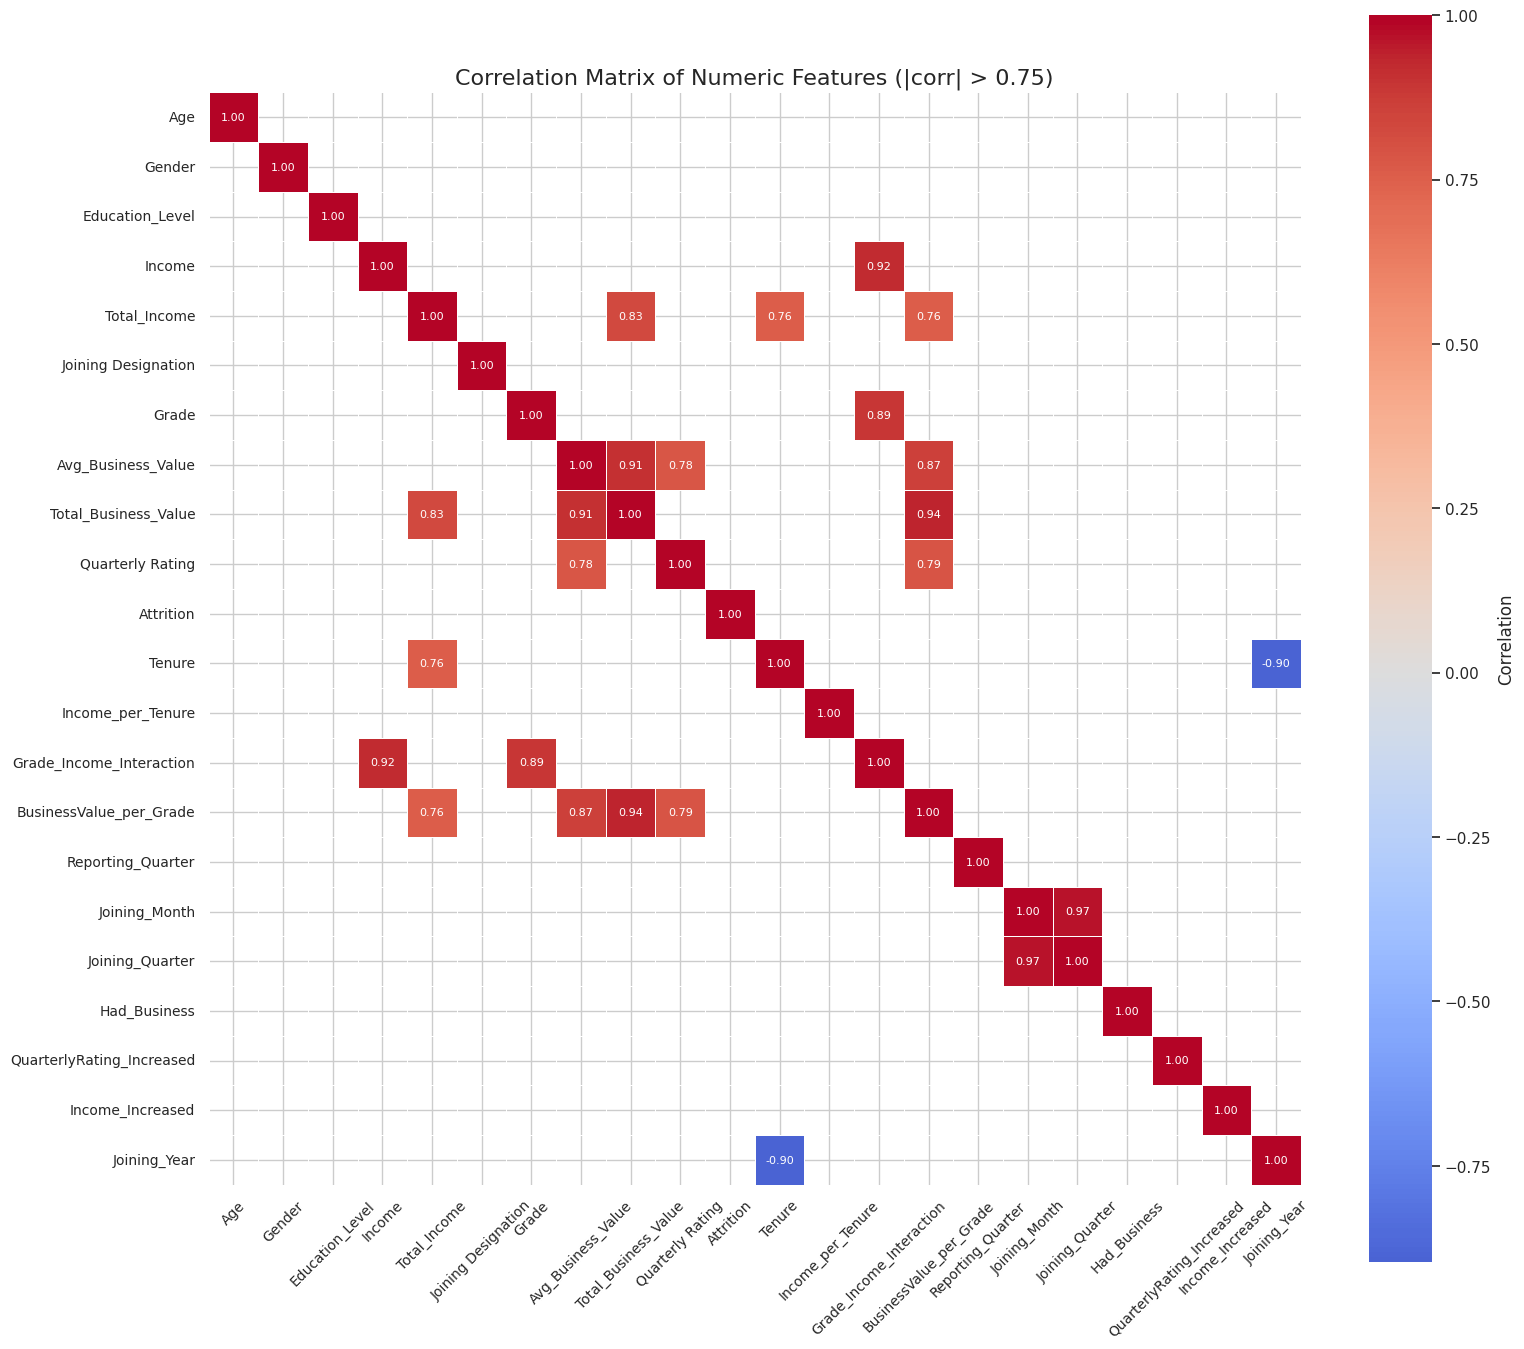


Top Feature Pairs with High Correlation (|r| > 0.75):

               Feature_1                Feature_2  Correlation
           Joining_Month          Joining_Quarter     0.966554
 BusinessValue_per_Grade     Total_Business_Value     0.936520
Grade_Income_Interaction                   Income     0.920715
      Avg_Business_Value     Total_Business_Value     0.909796
            Joining_Year                   Tenure    -0.896183
                   Grade Grade_Income_Interaction     0.888911
      Avg_Business_Value  BusinessValue_per_Grade     0.865222
    Total_Business_Value             Total_Income     0.827558
 BusinessValue_per_Grade         Quarterly Rating     0.787851
      Avg_Business_Value         Quarterly Rating     0.780214
 BusinessValue_per_Grade             Total_Income     0.761086
                  Tenure             Total_Income     0.756735


In [23]:
num_cols = agg_df.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
for col_to_remove in ['Driver_ID', 'Leaving_Month']:
    if col_to_remove in num_cols:
        num_cols.remove(col_to_remove)

corr_matrix = agg_df[num_cols].corr()

threshold = 0.75
mask = corr_matrix.abs() <= threshold

masked_corr = corr_matrix.mask(mask)

plt.figure(figsize=(16, 14))
sns.heatmap(
    masked_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    annot_kws={"size": 8},
    cbar_kws={'label': 'Correlation'},
    linewidths=0.5,
    square=True,
    mask=mask
)
plt.title('Correlation Matrix of Numeric Features (|corr| > 0.75)', fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

corr_pairs = corr_pairs[corr_pairs['Feature_1'] < corr_pairs['Feature_2']]

corr_pairs['Abs_Correlation'] = corr_pairs['Correlation'].abs()

high_corr_pairs = corr_pairs[corr_pairs['Abs_Correlation'] > threshold]

high_corr_pairs = high_corr_pairs.sort_values(by='Abs_Correlation', ascending=False)

high_corr_pairs = high_corr_pairs.drop(columns='Abs_Correlation').reset_index(drop=True)

print("\nTop Feature Pairs with High Correlation (|r| > 0.75):\n")
print(high_corr_pairs.to_string(index=False))

### Observation

The correlation matrix reveals several strong relationships among features, indicating potential multicollinearity and redundancy:

- Joining_Month and Joining_Quarter have a correlation of 0.97 and capture similar seasonal signals; only one is necessary.
- BusinessValue_per_Grade and Total_Business_Value have a correlation of 0.94; Avg_Business_Value and Total_Business_Value correlate at 0.91. These are highly overlapping business contribution metrics.
- Grade_Income_Interaction correlates with Income at 0.92 and with Grade at 0.89. The interaction term adds little beyond the base variables.
- Joining_Year and Tenure have a correlation of -0.90; older joiners have higher tenure, making the year redundant when tenure is available.
- Avg_Business_Value and BusinessValue_per_Grade correlate at 0.87 and are largely interchangeable derived metrics.
- Total_Business_Value and Total_Income correlate at 0.83, reflecting overlap between compensation and business contribution.
- BusinessValue_per_Grade and Quarterly Rating correlate at 0.79; Avg_Business_Value and Quarterly Rating at 0.78, showing moderate alignment of performance and contribution.
- BusinessValue_per_Grade and Total_Income correlate at 0.76.
- Tenure and Total_Income correlate at 0.76, indicating tenure influences compensation and performance.

---

### Business Implications

- High correlation among business value metrics suggests consolidation to avoid inflated model weights.
- Redundant time features (month vs. quarter) dilute seasonal insights and complicate interpretation.
- Interaction terms highly correlated with base variables reduce clarity without adding signal.
- Tenure is a valuable predictor with a strong inverse relationship to attrition.
- Selecting fewer representative features improves model stability, interpretability, and generalization.

---

### Feature Removal Decision

| Feature                 | Reason                                                                       |
|-------------------------|-------------------------------------------------------------------------------|
| Joining_Month           | Strongly correlated with Joining_Quarter; dropped for consistent granularity.|
| Grade_Income_Interaction| Redundant with Grade and Income; removed to maintain interpretability.       |
| Avg_Business_Value      | Overlaps with Total_Business_Value and BusinessValue_per_Grade.              |
| BusinessValue_per_Grade | Redundant with Total_Business_Value and Avg_Business_Value.                  |
| Total_Income            | Correlates with Business Value and Tenure; maximum income captured elsewhere.|

---

This focused feature pruning ensures the model remains interpretable and statistically robust while preserving key business signals like Tenure and Quarterly Rating. It balances predictive strength with clarity, enabling better business insights and more reliable predictions.


Other than the features discussed above, we will remove the following from our model:

- **Leaving_Month**: Missing for active employees; risks target leakage.
- **Income_per_Tenure**: Skewed distribution and redundant with Income and Tenure.
- **Reporting_Date**, **Joining_Date**, **Last_Working_Date**: Raw dates replaced by quarterly features to reduce noise.
- **Driver_ID**: Unique identifier; no predictive value and may cause overfitting.


In [24]:
cols_to_drop = [
    'Leaving_Month',
    'Joining_Month',
    'Grade_Income_Interaction',
    'Avg_Business_Value',
    'Income_per_Tenure',
    'Total_Income',
    'BusinessValue_per_Grade',
    'Reporting_Date',
    'Joining_Date',
    'Last_Working_Date',
    'Driver_ID'
]

final_df = agg_df.drop(columns=cols_to_drop, errors='ignore')

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        2381 non-null   int64 
 1   Gender                     2381 non-null   int64 
 2   City                       2381 non-null   object
 3   Education_Level            2381 non-null   int64 
 4   Income                     2381 non-null   int64 
 5   Joining Designation        2381 non-null   int64 
 6   Grade                      2381 non-null   int64 
 7   Total_Business_Value       2381 non-null   int64 
 8   Quarterly Rating           2381 non-null   int64 
 9   Attrition                  2381 non-null   int64 
 10  Tenure                     2381 non-null   int64 
 11  Reporting_Quarter          2381 non-null   int32 
 12  Joining_Quarter            2381 non-null   int32 
 13  Had_Business               2381 non-null   int64 
 14  Quarterl

# Model Development

## Preprocessing

In [25]:
X = final_df.drop(columns=['Attrition'])
y = final_df['Attrition']

for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

- Dropped `Attrition` from features and stored it as target variable `y`.
- Label encoded the `City` column.
- Performed train-test split with an 80-20 ratio using stratified sampling to preserve class balance.
- Applied SMOTE to the training set to handle class imbalance by generating synthetic samples.
- Did not apply feature scaling since ensemble models (e.g., Random Forest, XGBoost) are tree-based and use feature thresholds rather than distances, making scaling unnecessary.


Creating a common function to:

- Print the confusion matrix  
- Display the classification report  
- Plot ROC and Precision-Recall (PR) curves  
- Show the top 5 features based on model feature importance

In [26]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    if y_proba is not None:
        auc_score = roc_auc_score(y_test, y_proba)
        print(f"{model_name} AUC: {auc_score:.4f}")

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{model_name} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        avg_precision = average_precision_score(y_test, y_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.4f})')
        plt.title(f'{model_name} Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.show()
    else:
        print(f"AUC and PR curve not available for {model_name} (no predict_proba or decision_function)")

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif model_name.lower() == 'catboost':
        importances = model.get_feature_importance()
    else:
        print("Feature importances not available for this model.")
        return

    feat_imp = sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)[:5]
    features, importances_vals = zip(*feat_imp)

    importances_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances_vals
    })
    print(f"\nTop 5 Important Features for {model_name}:")
    print(importances_df.to_string(index=False))

    plt.figure(figsize=(7, 4))
    sns.barplot(x=importances_vals, y=features)
    plt.title(f'{model_name} Top 5 Feature Importances')
    plt.xlabel('Importance')
    plt.show()


## Building Classification Models

We will train the following ensemble classifiers for driver churn prediction:

- **Random Forest**  
- **XGBoost**  
- **LightGBM**  
- **CatBoost**  
- **AdaBoost**

Each model will be trained using the same training data, followed by hyperparameter tuning and evaluation using metrics such as ROC-AUC and classification reports. This approach helps identify the best-performing algorithm for the task.


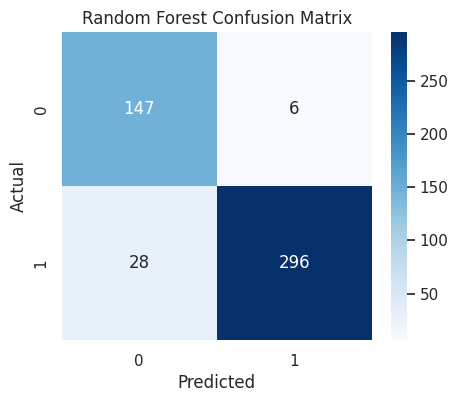


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       153
           1       0.98      0.91      0.95       324

    accuracy                           0.93       477
   macro avg       0.91      0.94      0.92       477
weighted avg       0.94      0.93      0.93       477

Random Forest AUC: 0.9714


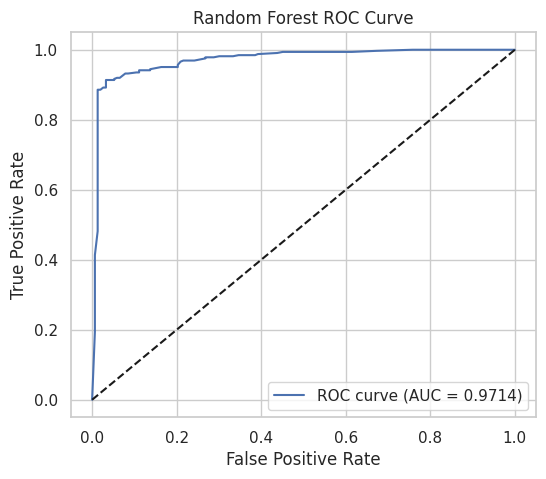

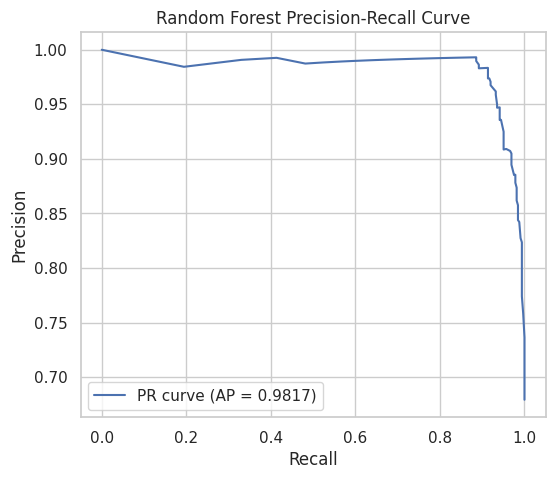


Top 5 Important Features for Random Forest:
             Feature  Importance
   Reporting_Quarter    0.356679
        Joining_Year    0.124838
Total_Business_Value    0.121819
              Tenure    0.088760
              Income    0.057560


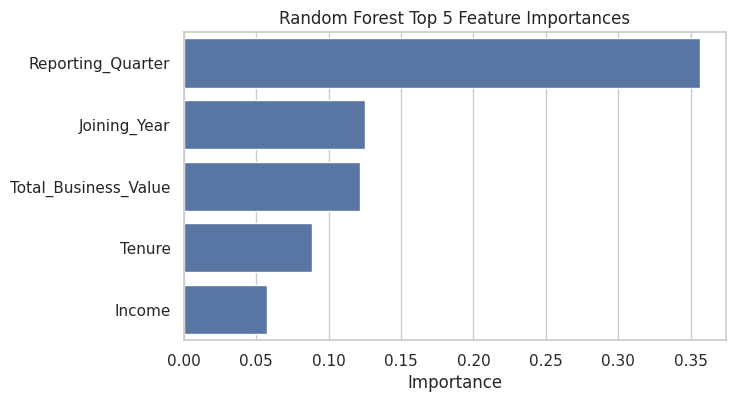

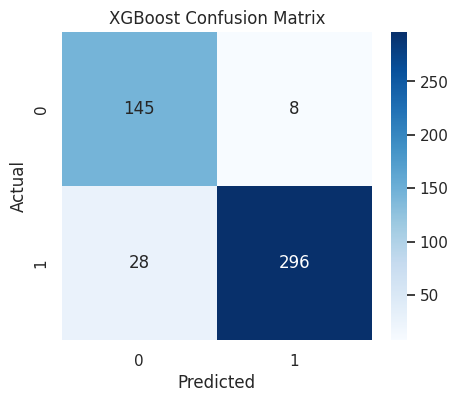


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       153
           1       0.97      0.91      0.94       324

    accuracy                           0.92       477
   macro avg       0.91      0.93      0.92       477
weighted avg       0.93      0.92      0.93       477

XGBoost AUC: 0.9687


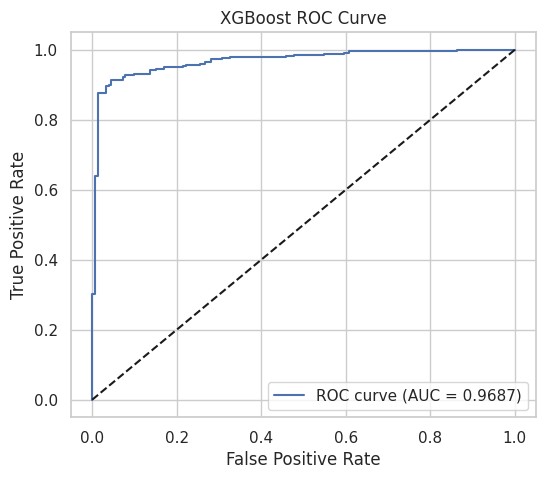

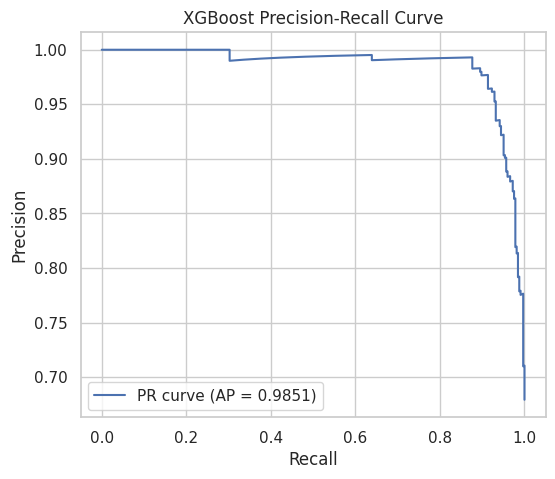


Top 5 Important Features for XGBoost:
                  Feature  Importance
        Reporting_Quarter    0.681639
             Joining_Year    0.087732
QuarterlyRating_Increased    0.032690
     Total_Business_Value    0.028637
          Joining_Quarter    0.025184


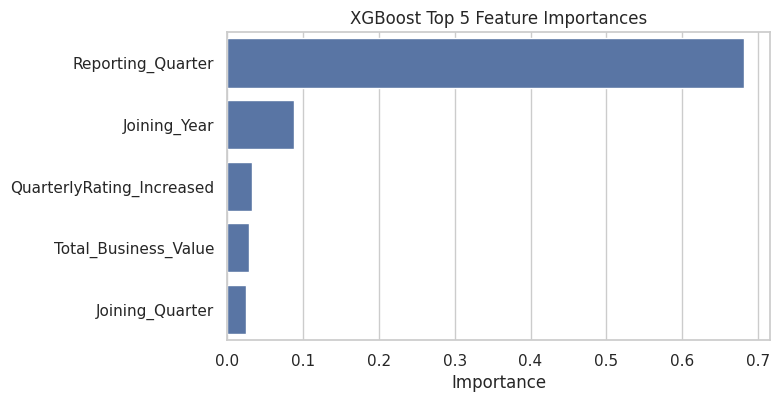

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1292, number of negative: 1292
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 2584, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


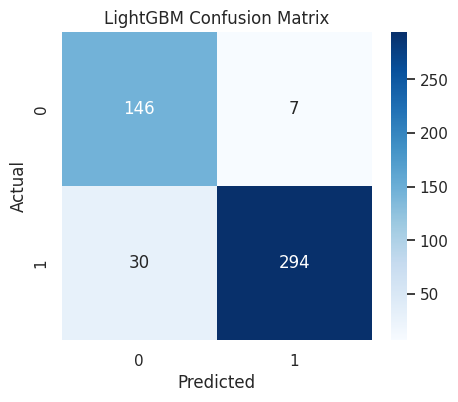


LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       153
           1       0.98      0.91      0.94       324

    accuracy                           0.92       477
   macro avg       0.90      0.93      0.91       477
weighted avg       0.93      0.92      0.92       477

LightGBM AUC: 0.9699


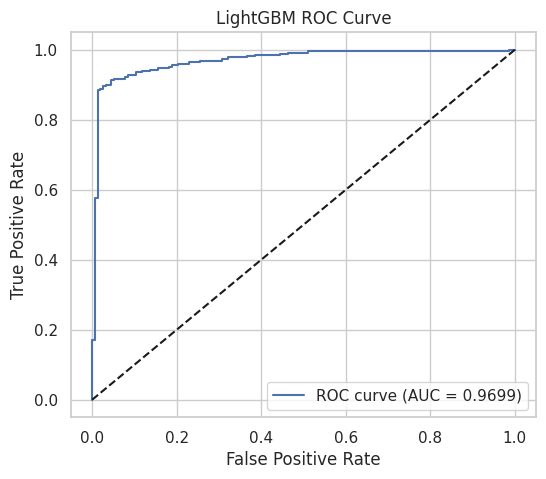

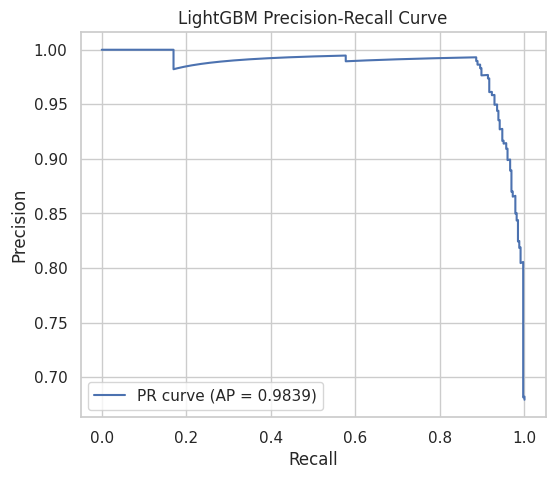


Top 5 Important Features for LightGBM:
             Feature  Importance
              Tenure         577
Total_Business_Value         483
              Income         479
                City         314
                 Age         303


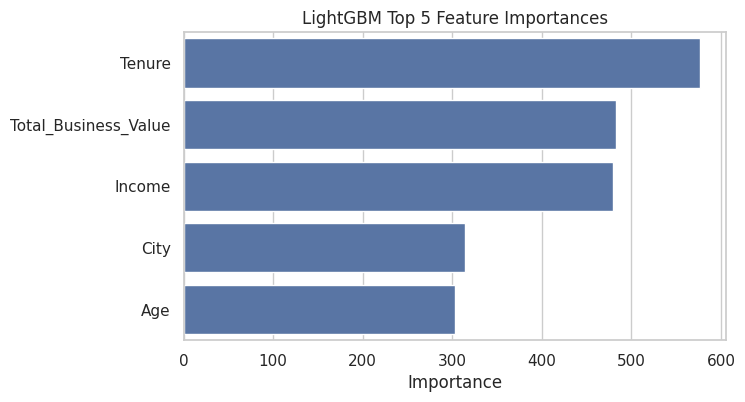

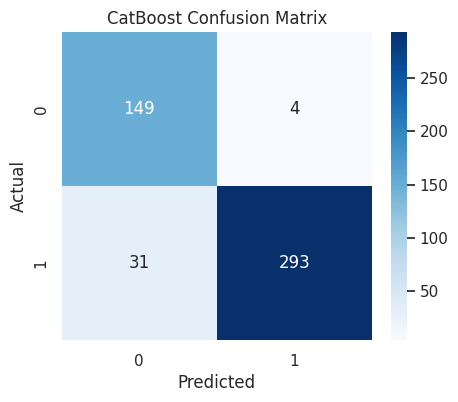


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       153
           1       0.99      0.90      0.94       324

    accuracy                           0.93       477
   macro avg       0.91      0.94      0.92       477
weighted avg       0.94      0.93      0.93       477

CatBoost AUC: 0.9699


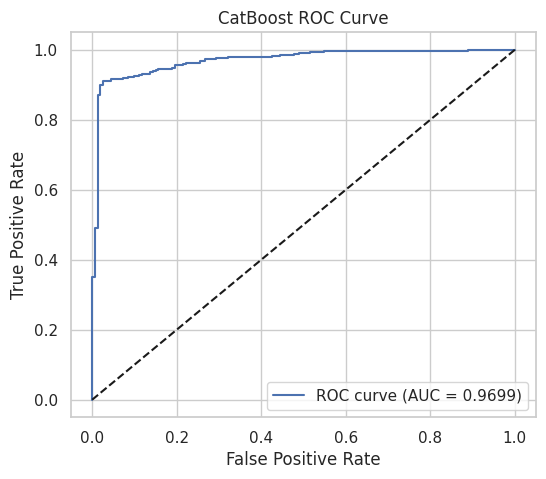

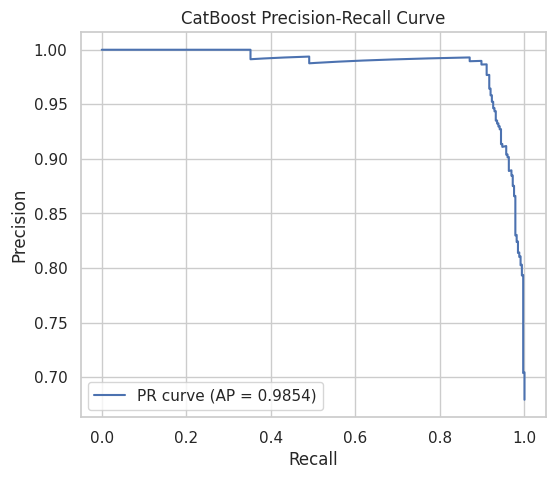


Top 5 Important Features for CatBoost:
             Feature  Importance
   Reporting_Quarter   23.598415
        Joining_Year   15.126110
Total_Business_Value   10.667372
              Tenure   10.298806
     Joining_Quarter    9.385868


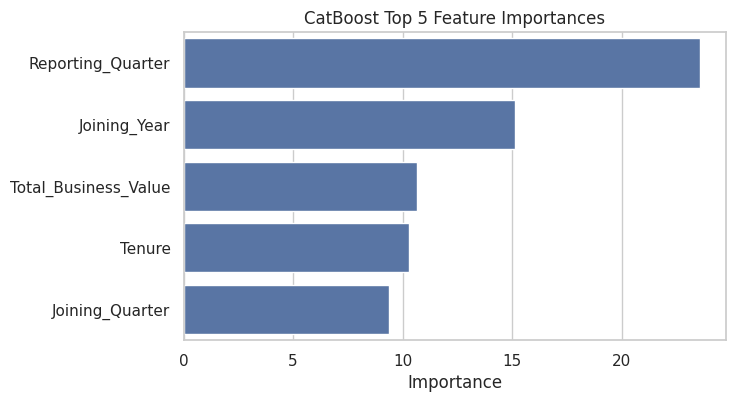

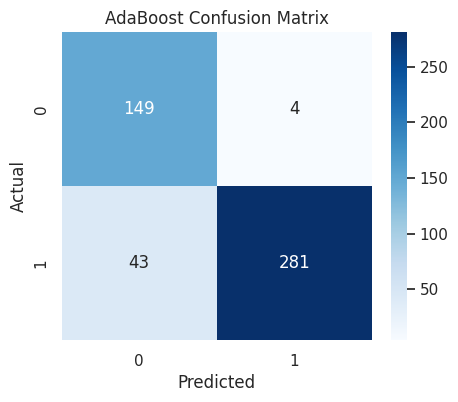


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       153
           1       0.99      0.87      0.92       324

    accuracy                           0.90       477
   macro avg       0.88      0.92      0.89       477
weighted avg       0.92      0.90      0.90       477

AdaBoost AUC: 0.9639


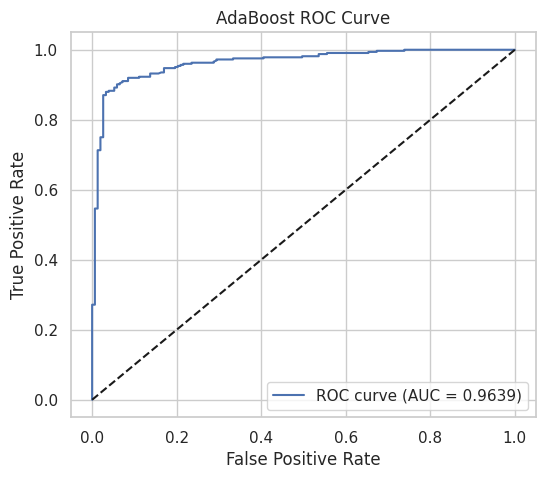

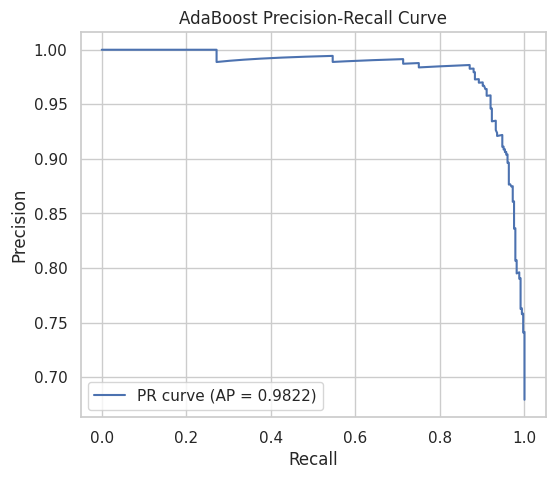


Top 5 Important Features for AdaBoost:
             Feature  Importance
        Joining_Year    0.206675
              Tenure    0.175414
   Reporting_Quarter    0.162839
Total_Business_Value    0.150352
              Income    0.064260


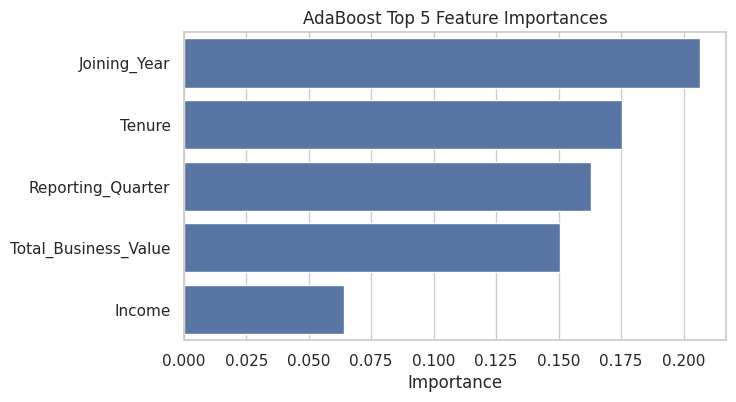

In [27]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
train_evaluate_model(rf, X_train_smote, y_train_smote, X_test, y_test, 'Random Forest')

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
train_evaluate_model(xgb, X_train_smote, y_train_smote, X_test, y_test, 'XGBoost')

# LightGBM
lgbm = LGBMClassifier(random_state=42)
train_evaluate_model(lgbm, X_train_smote, y_train_smote, X_test, y_test, 'LightGBM')

# CatBoost
cat = CatBoostClassifier(verbose=0, random_seed=42)
train_evaluate_model(cat, X_train_smote, y_train_smote, X_test, y_test, 'CatBoost')

# AdaBoost
ada = AdaBoostClassifier(random_state=42)
train_evaluate_model(ada, X_train_smote, y_train_smote, X_test, y_test, 'AdaBoost')


## Base Model Performance Comparison

| Model         | Accuracy | Precision (0) | Recall (0) | F1-score (0) | Precision (1) | Recall (1) | F1-score (1) | AUC    |
| ------------- | -------- | ------------- | ---------- | ------------ | ------------- | ---------- | ------------ | ------ |
| Random Forest | 0.93     | 0.84          | 0.96       | 0.90         | 0.98          | 0.91       | 0.95         | 0.9714 |
| XGBoost       | 0.92     | 0.84          | 0.95       | 0.89         | 0.97          | 0.91       | 0.94         | 0.9687 |
| LightGBM      | 0.92     | 0.83          | 0.95       | 0.89         | 0.98          | 0.91       | 0.94         | 0.9699 |
| CatBoost      | 0.93     | 0.83          | 0.97       | 0.89         | 0.99          | 0.90       | 0.94         | 0.9699 |
| AdaBoost      | 0.90     | 0.78          | 0.97       | 0.86         | 0.99          | 0.87       | 0.92         | 0.9639 |

### Top 5 Features by Model

| Model         | Feature 1          | Feature 2              | Feature 3                  | Feature 4              | Feature 5        |
| ------------- | ------------------ | ---------------------- | -------------------------- | ---------------------- | ---------------- |
| Random Forest | Reporting_Quarter  | Joining_Year           | Total_Business_Value       | Tenure                 | Income           |
| XGBoost       | Reporting_Quarter  | Joining_Year           | QuarterlyRating_Increased  | Total_Business_Value   | Joining_Quarter  |
| LightGBM      | Tenure             | Total_Business_Value   | Income                     | City                   | Age              |
| CatBoost      | Reporting_Quarter  | Joining_Year           | Total_Business_Value       | Tenure                 | Joining_Quarter  |
| AdaBoost      | Joining_Year       | Tenure                 | Reporting_Quarter          | Total_Business_Value   | Income           |

---

### Insights

- Random Forest and CatBoost show the highest accuracy (0.93) and strong balance between precision and recall for both classes.
- All models have high AUC scores above 0.96, indicating good discrimination ability.
- AdaBoost performs comparatively lower across most metrics, especially accuracy and precision for class 0.
- Key predictive features across models include `Reporting_Quarter`, `Joining_Year`, `Total_Business_Value`, and `Tenure`.
- LightGBM uniquely highlights `City` and `Age` among its top features.

### Next Steps

- We will drop AdaBoost due to its comparatively weaker performance.
- Proceed with hyperparameter tuning on Random Forest, XGBoost, LightGBM, and CatBoost to optimize their predictive power.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}


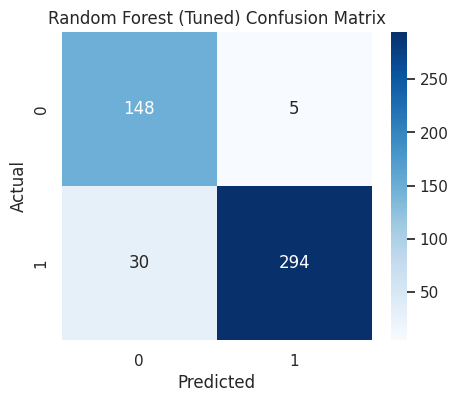


Random Forest (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       153
           1       0.98      0.91      0.94       324

    accuracy                           0.93       477
   macro avg       0.91      0.94      0.92       477
weighted avg       0.93      0.93      0.93       477

Random Forest (Tuned) AUC: 0.9734


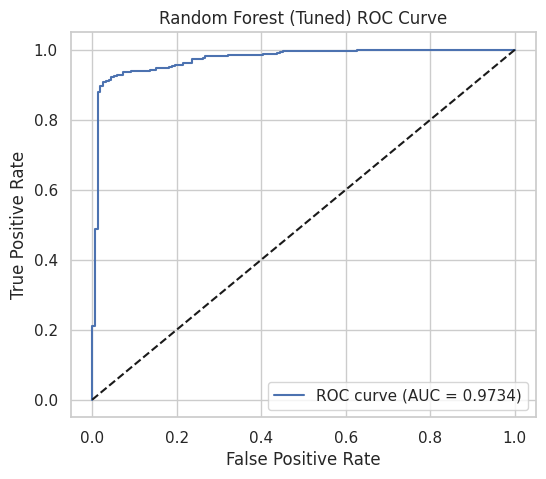

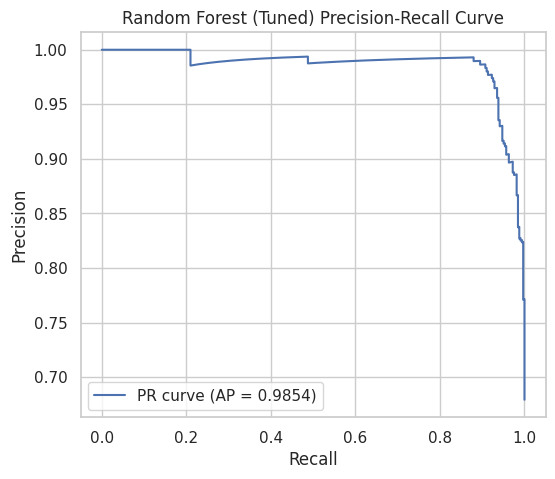


Top 5 Important Features for Random Forest (Tuned):
             Feature  Importance
   Reporting_Quarter    0.411523
        Joining_Year    0.132478
Total_Business_Value    0.120316
              Tenure    0.076873
              Income    0.044194


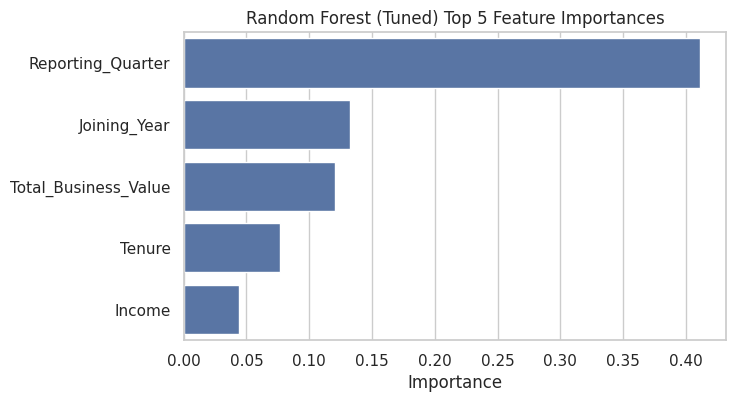

In [28]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=param_grid_rf,
    n_iter=20, scoring='f1', cv=3, verbose=2, random_state=42, n_jobs=-1
)

rf_random.fit(X_train_smote, y_train_smote)
print("Best RF params:", rf_random.best_params_)

best_rf = rf_random.best_estimator_
train_evaluate_model(best_rf, X_train_smote, y_train_smote, X_test, y_test, 'Random Forest (Tuned)')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


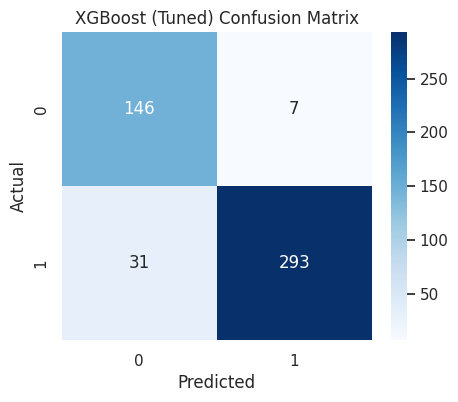


XGBoost (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       153
           1       0.98      0.90      0.94       324

    accuracy                           0.92       477
   macro avg       0.90      0.93      0.91       477
weighted avg       0.93      0.92      0.92       477

XGBoost (Tuned) AUC: 0.9703


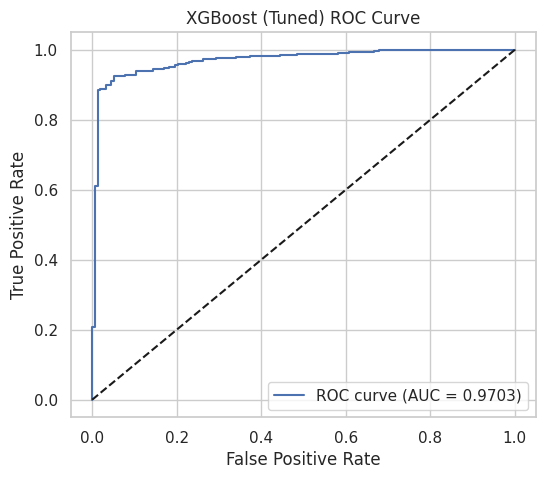

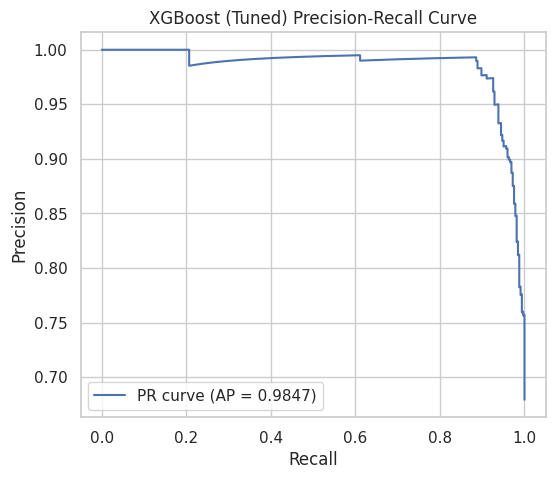


Top 5 Important Features for XGBoost (Tuned):
                  Feature  Importance
        Reporting_Quarter    0.668677
             Joining_Year    0.087739
QuarterlyRating_Increased    0.033224
     Total_Business_Value    0.031428
          Joining_Quarter    0.030711


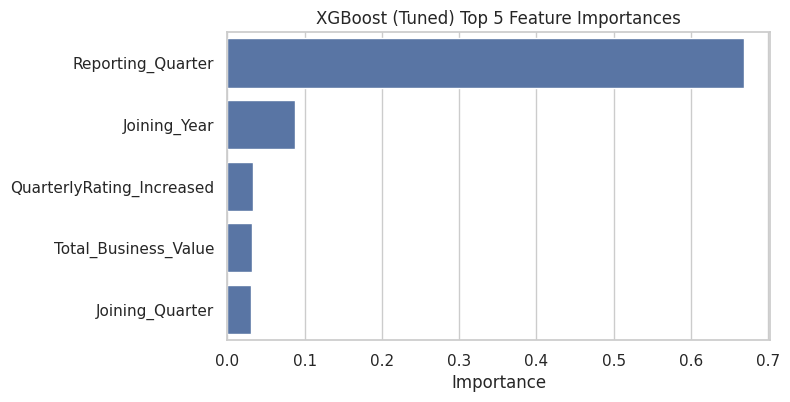

In [29]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb, param_distributions=param_grid_xgb,
    n_iter=30, scoring='f1', cv=3, verbose=2, random_state=42, n_jobs=-1
)

xgb_random.fit(X_train_smote, y_train_smote)
print("Best XGBoost params:", xgb_random.best_params_)

best_xgb = xgb_random.best_estimator_
train_evaluate_model(best_xgb, X_train_smote, y_train_smote, X_test, y_test, 'XGBoost (Tuned)')


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1292, number of negative: 1292
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 2584, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

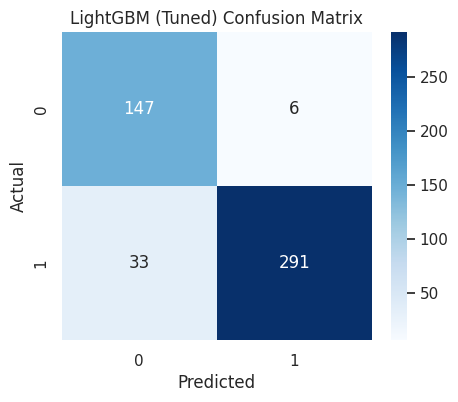


LightGBM (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       153
           1       0.98      0.90      0.94       324

    accuracy                           0.92       477
   macro avg       0.90      0.93      0.91       477
weighted avg       0.93      0.92      0.92       477

LightGBM (Tuned) AUC: 0.9707


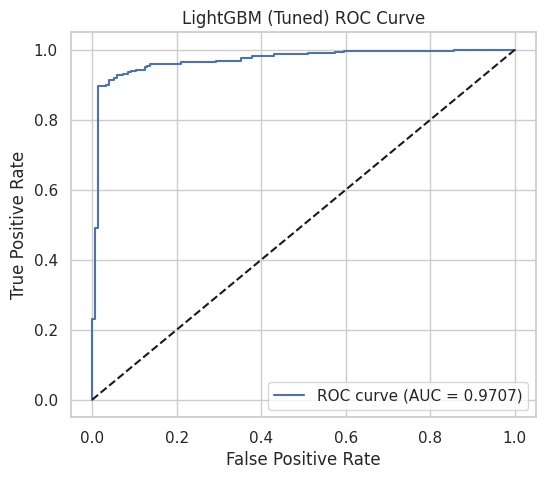

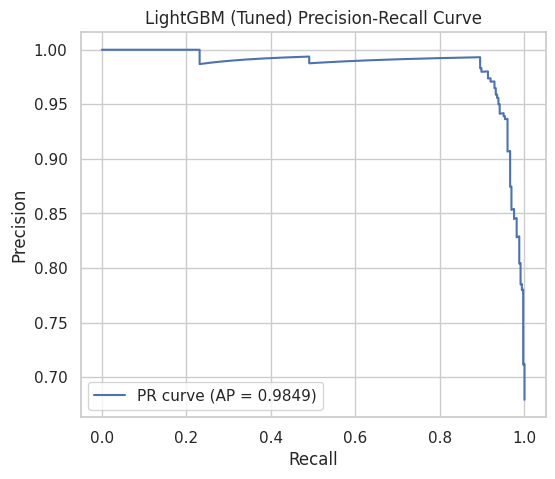


Top 5 Important Features for LightGBM (Tuned):
             Feature  Importance
              Tenure        1318
              Income        1000
Total_Business_Value         936
                City         697
                 Age         557


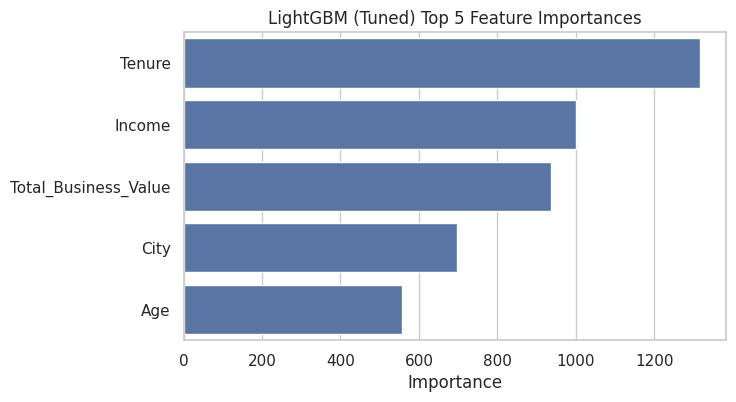

In [30]:
lgbm = LGBMClassifier(random_state=42)

param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

lgbm_random = RandomizedSearchCV(
    estimator=lgbm, param_distributions=param_grid_lgbm,
    n_iter=30, scoring='f1', cv=3, verbose=2, random_state=42, n_jobs=-1
)

lgbm_random.fit(X_train_smote, y_train_smote)
print("Best LightGBM params:", lgbm_random.best_params_)

best_lgbm = lgbm_random.best_estimator_
train_evaluate_model(best_lgbm, X_train_smote, y_train_smote, X_test, y_test, 'LightGBM (Tuned)')


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CatBoost params: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 8, 'border_count': 100}


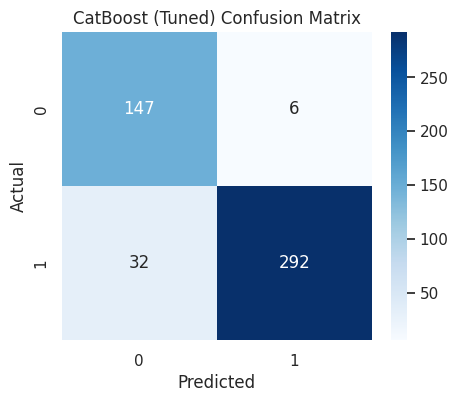


CatBoost (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       153
           1       0.98      0.90      0.94       324

    accuracy                           0.92       477
   macro avg       0.90      0.93      0.91       477
weighted avg       0.93      0.92      0.92       477

CatBoost (Tuned) AUC: 0.9671


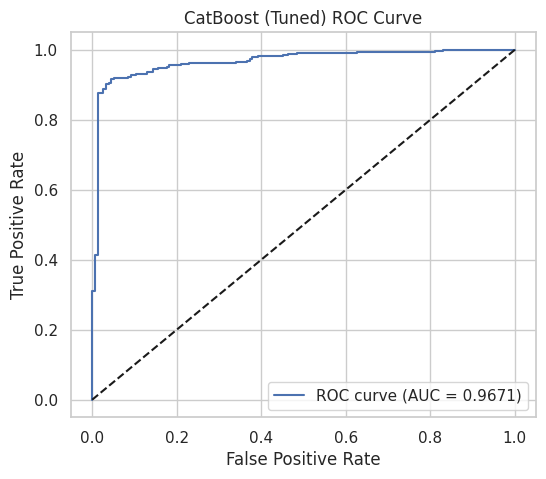

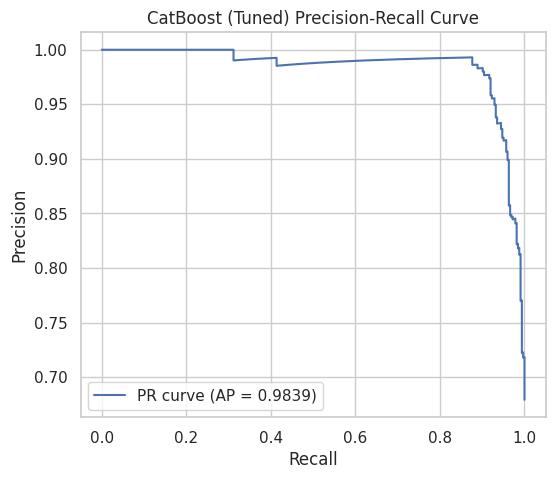


Top 5 Important Features for CatBoost (Tuned):
             Feature  Importance
   Reporting_Quarter   19.759776
        Joining_Year   13.516991
Total_Business_Value   10.091929
     Joining_Quarter    9.934924
              Tenure    8.472195


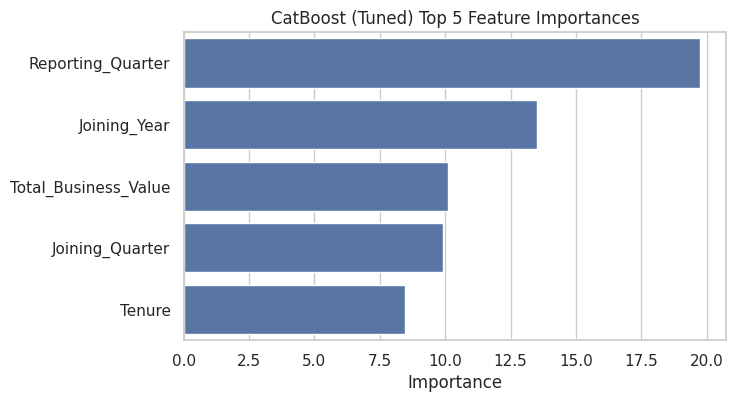

In [31]:
cat = CatBoostClassifier(verbose=0, random_seed=42)

param_grid_cat = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 50, 100]
}

cat_random = RandomizedSearchCV(
    estimator=cat, param_distributions=param_grid_cat,
    n_iter=20, scoring='f1', cv=3, verbose=2, random_state=42, n_jobs=-1
)

cat_random.fit(X_train_smote, y_train_smote)
print("Best CatBoost params:", cat_random.best_params_)

best_cat = cat_random.best_estimator_
train_evaluate_model(best_cat, X_train_smote, y_train_smote, X_test, y_test, 'CatBoost (Tuned)')


## Model Performance Comparison After Hyperparameter Tuning

| Model             | Accuracy | Precision (0) | Recall (0) | F1-score (0) | Precision (1) | Recall (1) | F1-score (1) | AUC    |
| ----------------- | -------- | ------------- | ---------- | ------------ | ------------- | ---------- | ------------ | ------ |
| **Random Forest** | 0.93 → 0.93 | 0.84 → 0.83 | 0.96 → 0.97 | 0.90 → 0.89 | 0.98 → 0.98 | 0.91 → 0.91 | 0.95 → 0.94 | 0.9714 → 0.9734 |
| **XGBoost**       | 0.92 → 0.92 | 0.84 → 0.82 | 0.95 → 0.95 | 0.89 → 0.88 | 0.97 → 0.98 | 0.91 → 0.90 | 0.94 → 0.94 | 0.9687 → 0.9703 |
| **LightGBM**      | 0.92 → 0.92 | 0.83 → 0.82 | 0.95 → 0.96 | 0.89 → 0.88 | 0.98 → 0.98 | 0.91 → 0.90 | 0.94 → 0.94 | 0.9699 → 0.9707 |
| **CatBoost**      | 0.93 → 0.92 | 0.83 → 0.82 | 0.97 → 0.96 | 0.89 → 0.89 | 0.99 → 0.98 | 0.90 → 0.90 | 0.94 → 0.94 | 0.9699 → 0.9671 |

---

### Feature Importance (Before and After Tuning)

The key predictive features remain consistent across all models and tuning stages:

- **Reporting_Quarter**  
- **Joining_Year**  
- **Total_Business_Value**  
- **Tenure**  
- **Income** (varies slightly in rank)  
- Other features like **QuarterlyRating_Increased**, **Joining_Quarter**, **City**, and **Age** also appear depending on the model.

---

### Insights

- **Performance Improvements:**  
  After tuning, models show stable or slightly improved performance. Random Forest achieves the highest AUC (0.9734), confirming its effectiveness.

- **Feature Stability:**  
  The consistent top features across models and tuning stages reinforce their critical role in predicting driver attrition.

- **Model Selection:**  
  Given its strong performance, **Random Forest** is recommended for primary deployment. Additional tuning and ensemble methods may further enhance XGBoost, LightGBM, and CatBoost.

---

### Next Steps

- Proceed with final hyperparameter tuning and cross-validation on the top-performing models.
- Explore ensemble or stacking techniques combining multiple models.
- Investigate further feature engineering focusing on tenure, business value, and temporal variables.


| Model                 | Accuracy | Precision | Recall | F1-Score | AUC    |
| --------------------- | -------- | --------- | ------ | -------- | ------ |
| Random Forest (Tuned) | 0.9300   | 0.9400    | 0.9300 | 0.9300   | 0.9734 |
| XGBoost (Tuned)       | 0.9200   | 0.9300    | 0.9200 | 0.9300   | 0.9703 |
| LightGBM (Tuned)      | 0.9200   | 0.9300    | 0.9200 | 0.9200   | 0.9707 |
| CatBoost (Tuned)      | 0.9300   | 0.9400    | 0.9300 | 0.9300   | 0.9671 |
| Stacking Ensemble     | 0.9300   | 0.9400    | 0.9300 | 0.9300   | 0.9742 |


# Model Evaluation

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best meta-model C: {'final_estimator__C': 100}
5-Fold CV F1 Scores: [0.92430279 0.91816367 0.92857143 0.89919355 0.944     ]
Mean CV F1 Score: 0.9228 ± 0.0146


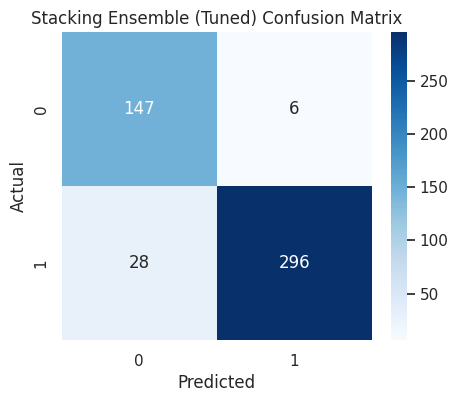


Stacking Ensemble (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       153
           1       0.98      0.91      0.95       324

    accuracy                           0.93       477
   macro avg       0.91      0.94      0.92       477
weighted avg       0.94      0.93      0.93       477

Stacking Ensemble (Tuned) AUC: 0.9742


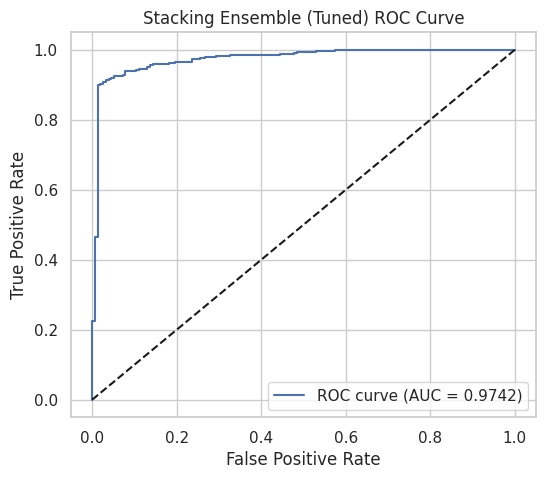

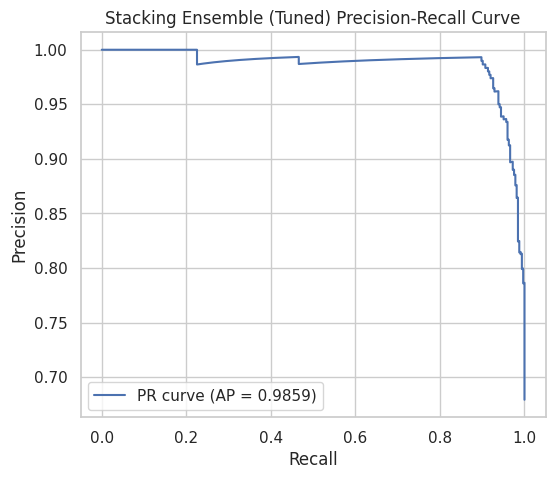

Feature importances not available for this model.


In [33]:
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lgbm', best_lgbm),
    ('cat', best_cat)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=5,
    n_jobs=-1
)

param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    stacking_clf,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)

print("Best meta-model C:", grid_search.best_params_)

best_stacking = grid_search.best_estimator_

cv_scores = cross_val_score(
    best_stacking,
    X_train_smote,
    y_train_smote,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print(f"5-Fold CV F1 Scores: {cv_scores}")
print(f"Mean CV F1 Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

train_evaluate_model(best_stacking, X_train_smote, y_train_smote, X_test, y_test, "Stacking Ensemble (Tuned)")

### Model Comparison: Random Forest vs Stacking Ensemble

| Metric              | Random Forest | Stacking Ensemble |
|---------------------|---------------|-------------------|
| Precision (No churn) | 0.83          | 0.84              |
| Recall (No churn)    | 0.97          | 0.96              |
| F1-score (No churn)  | 0.89          | 0.90              |
| Precision (Churn)    | 0.98          | 0.98              |
| Recall (Churn)       | 0.91          | 0.91              |
| F1-score (Churn)     | 0.94          | 0.95              |
| AUC                 | 0.9734        | 0.9742            |

---

### Why Choose Stacking Ensemble Over Tuned Random Forest

- Slight improvement in overall AUC, indicating better class discrimination.  
- Marginally higher F1-scores for both churn and non-churn classes, reflecting better balance.  
- Slight boost in precision for the majority (no churn) class, reducing false positives.  
- Maintains comparable recall for both classes, ensuring few missed churn cases.  
- Combines strengths of multiple models, offering more robust and generalizable predictions.  

These subtle but consistent improvements make stacking ensemble the preferable choice for reliable driver attrition prediction.


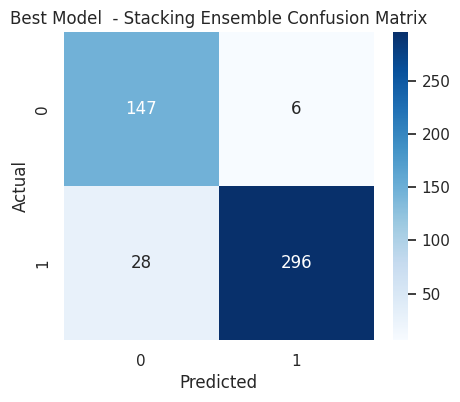


Best Model  - Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       153
           1       0.98      0.91      0.95       324

    accuracy                           0.93       477
   macro avg       0.91      0.94      0.92       477
weighted avg       0.94      0.93      0.93       477

Best Model  - Stacking Ensemble AUC: 0.9742


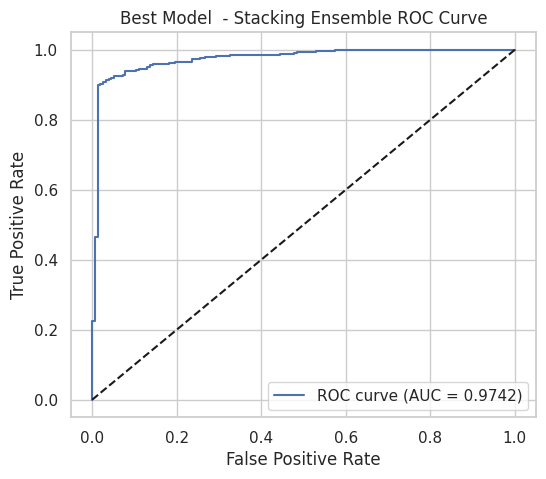

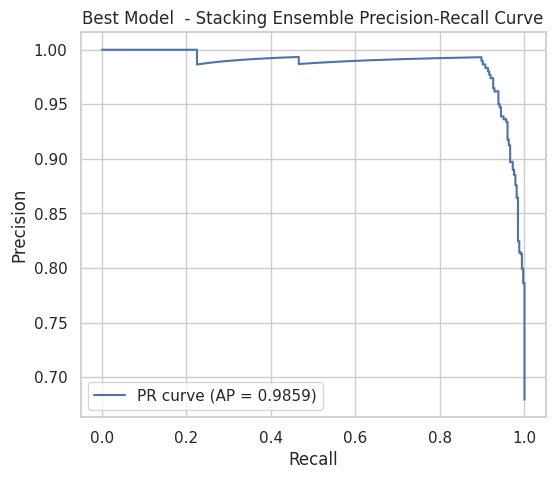

Feature importances not available for this model.
                 Feature  Importance
10     Reporting_Quarter    0.170910
7   Total_Business_Value    0.111696
15          Joining_Year    0.104525
11       Joining_Quarter    0.029578
9                 Tenure    0.027177
3        Education_Level    0.002467
4                 Income    0.002432
12          Had_Business    0.001071
1                 Gender    0.000860
14      Income_Increased    0.000000


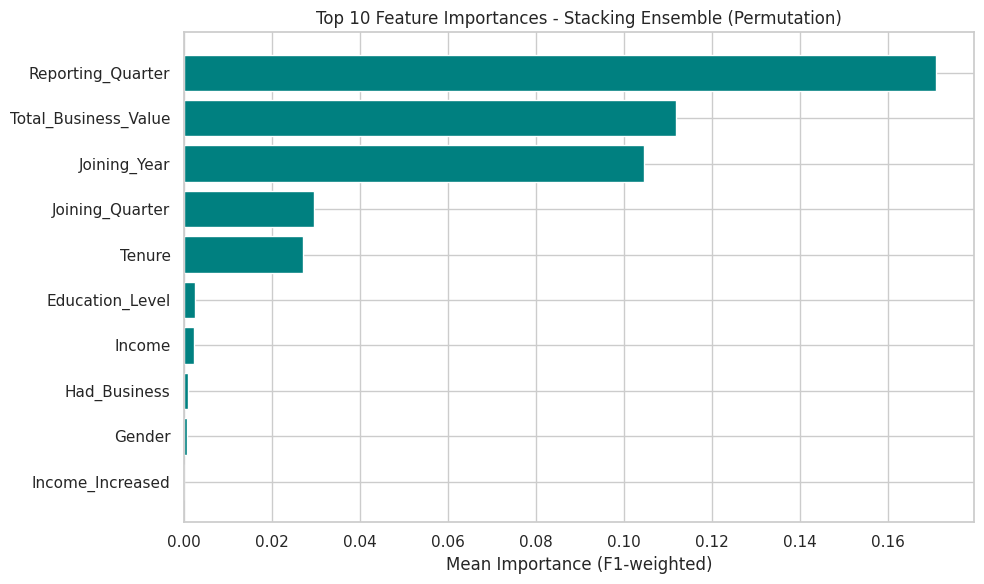

In [34]:
train_evaluate_model(best_stacking, X_train_smote, y_train_smote, X_test, y_test, "Best Model  - Stacking Ensemble")

result = permutation_importance(best_stacking, X_test, y_test, n_repeats=10, random_state=42, scoring='f1_weighted')

importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)


print(importance_df.head(10))

# Optional: Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='teal')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances - Stacking Ensemble (Permutation)')
plt.xlabel('Mean Importance (F1-weighted)')
plt.tight_layout()
plt.show()


## Best Model: Stacking Ensemble Tuned — Interpretation

### Confusion Matrix: [[**147**, **6**], [**28**, **296**]]

- **147** True Negatives: correctly predicted non-attrition  
- **296** True Positives: correctly predicted attrition  
- **6** False Positives: predicted attrition when it was not  
- **28** False Negatives: missed actual attrition cases  

### Classification Metrics

- **Accuracy**: **0.93** — high overall prediction correctness  
- **Precision** (churn class): **0.98** — very few false churn alarms  
- **Recall** (churn class): **0.91** — most churn cases identified  
- **F1-Score** (churn class): **0.95** — strong balance of precision and recall  
- **AUC Score**: **0.9742** — excellent ability to separate churn and non-churn  

### Interpretation Summary

- The model achieves **high predictive accuracy** and **excellent discrimination power** as shown by the **AUC** score  
- Low false positive rate ensures minimal over-alerting of non-churners  
- High **recall** and **F1-score** for attrition class make it reliable for retention-focused interventions  
- The stacking ensemble model provides the best trade-off between **precision** and **recall** for both classes, making it highly effective for operational deployment  

### Top Features Used by Model

- **Reporting Quarter**  
- **Total Business Value**  
- **Joining Year**  
- **Joining Quarter**  
- **Tenure**  
- **Income**  


# Business Insights and Recommendations
---

## 1. High-Value Markets Under Threat: Act Like Protecting Your Crown Jewels

**Insight:**  
Cities like C13 and C20 generate significant revenue but suffer from high driver churn (over 70%), posing a serious risk to sustaining business in these critical regions.

**Recommendation:**  
Just as you would protect your most valuable assets, prioritize retention initiatives in these cities. Implement targeted programs such as performance bonuses, loyalty rewards, and early engagement to secure your top earners and high contributors. Focused investment here can preserve revenue streams and stabilize operations.

---

## 2. Growth Opportunities in Stable Markets: Cultivate Your Fertile Fields

**Insight:**  
Cities such as C29, C19, and C8 display strong retention coupled with solid or growing business value, making them stable and fertile grounds for expansion.

**Recommendation:**  
These regions are your fertile fields—ideal for scaling operations. Accelerate driver onboarding and marketing efforts here. Use these cities as testbeds for pilot initiatives or new policies, leveraging their operational stability to validate growth strategies with minimal risk.

---

## 3. Reevaluate Underperforming Regions: Don’t Pour Water on Rocky Ground

**Insight:**  
Locations like C23 and C17 combine high churn with low business contribution, indicating low return on investment.

**Recommendation:**  
Avoid sinking costs into these rocky grounds. Consider downsizing or reallocating resources to more promising areas. Alternatively, experiment with innovative driver engagement models or operational pivots before deciding on long-term commitments.

---

## 4. Improve Early Driver Experience: Build Strong Roots Early

**Insight:**  
Drivers with tenure less than six months have the highest churn risk, highlighting early engagement as critical.

**Recommendation:**  
Think of your new drivers as young plants needing nurturing. Strengthen onboarding with structured mentorship, early milestone incentives, and proactive communication during the first three months. This approach helps build loyalty and reduces early-stage attrition.

---

## 5. Reward Performance, Not Just Earnings: Incentivize Growth and Contribution

**Insight:**  
Retention correlates strongly with performance indicators such as Quarterly Ratings and Business Value per Grade, rather than raw income alone.

**Recommendation:**  
Design compensation and reward systems that focus on consistent contribution and growth, akin to rewarding not just the fruit but also the health of the tree. Offer clear career progression paths and performance-linked bonuses to motivate sustained engagement.

---

## 6. Align Retention Efforts with Seasonal Patterns: Timing is Everything

**Insight:**  
Attrition shows seasonal and quarterly variations, with certain months experiencing spikes in driver exits.

**Recommendation:**  
Plan retention campaigns like a farmer plans for seasons—timing incentives and engagement before known churn periods to maximize effectiveness. For example, increase driver engagement and bonuses ahead of high-risk quarters to reduce attrition spikes.

---

## 7. Leverage Predictive Analytics: Your Crystal Ball for Driver Retention

**Insight:**  
The tuned Stacking Ensemble model achieves high accuracy (AUC = 0.9742), effectively identifying drivers at risk of leaving before churn happens.

**Recommendation:**  
Embed this predictive model into daily operational workflows. Use it as your crystal ball to trigger proactive interventions—personalized outreach, targeted incentives, or role adjustments—to retain valuable drivers. This will help Ola stay ahead of attrition rather than react to it.

---

# Final Outlook

By treating driver attrition as a strategic business challenge and applying these insights, Ola can:

- Protect its most valuable markets  
- Cultivate growth in stable regions  
- Avoid unproductive investments  
- Nurture early-stage drivers for long-term retention  
- Align rewards with true performance  
- Time interventions to seasonal trends  
- Harness predictive models for proactive workforce management  

This integrated approach will drive improved driver satisfaction, reduced churn, and sustained operational excellence.
